In [7]:
# Importar as bibliotecas necessárias
import os
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

# Verificar se CUDA está disponível e definir o dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {device}")

# Definir as cores para as classes
CLASS_COLORS = { 
    'Doenca': (255, 0, 0), 
    'Saudavel': (0, 255, 0), 
    'Solo': (0, 0, 255) 
}

Usando o dispositivo: cuda


In [8]:
#definicao dos hiperparametros.
criterion = nn.CrossEntropyLoss()  # Considerando que temos múltiplas classes
learning_rate = 0.001
num_epochs = 300
patience = 30
batch_size = 32

In [9]:
# Classe do Dataset personalizado
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        # Modificar a extensão da máscara para '.png'
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Carregar a imagem e a máscara
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")
        
        if self.transform:
            # Aplicar transformações, se houver
            image = self.transform(image)
            mask = self.transform(mask)
            
        # Convertemos as máscaras de imagem em um array de índices de classe
        mask = self.mask_to_class(mask)
        
        return image, mask
    
    def mask_to_class(self, mask):
        # Converte a máscara para um array NumPy e ajusta para escala de 0 a 255
        mask_array = (np.array(mask, dtype=np.float32) * 255).astype(np.uint8)

        # Garantir que esté em [H, W, C]
        if mask_array.shape[0] == 3:
            mask_array = mask_array.transpose(1, 2, 0)

        mask_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.int64)

        for i, color in enumerate(CLASS_COLORS.values()):
            # Realizar comparação e detecção de igualdade entre pixels
            equal_color = np.all(mask_array == color, axis=-1)
            mask_indices[equal_color] = i

        return torch.tensor(mask_indices, dtype=torch.long)

# Função para criar transformações de dados normais e de aumento de dados
def get_transforms():
    return transforms.Compose([
        transforms.Resize((256, 256)),  # Redimensiona para uma dimensão adequada para o modelo
        transforms.ToTensor(),  # Normaliza para [0, 1]
    ])

# Outras inicializações de datasets e dataloaders
train_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Train",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Train",
    transform=get_transforms()
)

val_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Val",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Val",
    transform=get_transforms()
)

test_dataset = SegmentationDataset(
    image_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/base/Test",
    mask_dir="E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/dataset/masks/Test",
    transform=get_transforms()
)

# Criar os DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Dados carregados e preparados.")

Dados carregados e preparados.


In [10]:
# Importar a biblioteca segmentation-models-pytorch
!pip install segmentation-models-pytorch --quiet

import segmentation_models_pytorch as smp

# Inicializar as arquiteturas dos modelos com os pesos pretreinados por padrão
unet = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
pspnet = smp.PSPNet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
linknet = smp.Linknet(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)
deeplabv3 = smp.DeepLabV3(encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=len(CLASS_COLORS)).to(device)

models = {
    'U-Net': unet,
    'PSPNet': pspnet,
    'LinkNet': linknet,
    'DeepLabV3': deeplabv3
}

print("Modelos configurados e prontos para treinamento.")

Modelos configurados e prontos para treinamento.


In [11]:
import torch
import torchmetrics
import numpy as np
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassF1Score, MulticlassPrecision

def compute_dice_coefficient(preds, targets):
    """
    Calcula o coeficiente de Dice
    """
    intersection = (preds * targets).sum()
    dice = (2. * intersection) / (preds.sum() + targets.sum())
    return dice.item()

def compute_aji(preds, targets):
    """
    Calcula o índice de Jaccard agregado (AJI)
    """
    preds = preds.detach().cpu().numpy().astype(np.bool_)
    targets = targets.detach().cpu().numpy().astype(np.bool_)
    
    # Calcula o Jaccard para cada componente individual nos targets/preds
    intersection = np.logical_and(preds, targets)
    union = np.logical_or(preds, targets)
    jaccard_per_class = intersection.sum() / (union.sum() + 1e-10)  # Evitar divisão por zero
    return jaccard_per_class

# Configurar as métricas, incluindo Dice e AJI personalizados
metrics = {
    'F1': MulticlassF1Score(num_classes=len(CLASS_COLORS)).to(device),
    'Jaccard': MulticlassJaccardIndex(num_classes=len(CLASS_COLORS)).to(device),
    'Precision': MulticlassPrecision(num_classes=len(CLASS_COLORS)).to(device),
    'Dice': compute_dice_coefficient,
    'AJI': compute_aji
}

In [12]:
import csv
import time
import os

# Diretório para salvar os resultados
results_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/data"
os.makedirs(results_dir, exist_ok=True)

def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, metrics, num_epochs, device, patience, model_name, results_dir):
    since = time.time()
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience_counter = 0
    epochs_run = 0  # Variável para contar as épocas realizadas

    # Variáveis para armazenar tempos de execução
    training_time = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        epochs_run += 1  # Registrar a execução da época

        epoch_start = time.time()  # Marcar o início da época

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_metrics = {key: 0 for key in metrics.keys()}
            
            for inputs, masks in tqdm(data_loader):
                inputs, masks = inputs.to(device), masks.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                for metric_name, metric in metrics.items():
                    if metric_name in ['Dice', 'AJI']:
                        value = metric(preds, masks)
                    else:  # Para métricas torchmetrics
                        value = metric(preds, masks).item()
                    running_metrics[metric_name] += value * inputs.size(0)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_metrics = {key: value / len(data_loader.dataset) for key, value in running_metrics.items()}

            print(f'{phase} Loss: {epoch_loss:.4f}')
            for metric_name in metrics:
                print(f'{phase} {metric_name}: {epoch_metrics[metric_name]:.4f}')

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        epoch_end = time.time()  # Marcar o fim da época
        epoch_time = epoch_end - epoch_start
        training_time += epoch_time  # Acumular tempos totais
        print(f'Epoch time: {epoch_time:.2f} seconds')

        print(f'Patience counter: {patience_counter}')

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')
    print(f'Total epochs run: {epochs_run}')

    # Restaurar o melhor modelo
    model.load_state_dict(best_model_wts)

    # Salvar o modelo treinado
    model_path = os.path.join(results_dir, f'{model_name}_best.pth')
    torch.save(model.state_dict(), model_path)

    # Coletar as métricas finais
    final_metrics = epoch_metrics
    final_metrics['best_loss'] = best_loss
    final_metrics['training_time'] = time_elapsed
    final_metrics['epochs_run'] = epochs_run

    # Salvar todas as métricas para CSV
    csv_path = os.path.join(results_dir, 'results.csv')
    write_metrics_to_csv(csv_path, model_name, final_metrics)

    return model

def write_metrics_to_csv(csv_path, model_name, metrics):
    headers = ['nome', 'f1-score', 'indice jaccard', 'precision', 'dice', 'aji', 'best_loss', 'training_time', 'epochs_run']
    row = [
        model_name,
        metrics['F1'],
        metrics['Jaccard'],
        metrics['Precision'],
        metrics['Dice'],
        metrics['AJI'],
        metrics['best_loss'],
        metrics['training_time'],
        metrics['epochs_run']
    ]

    file_exists = os.path.isfile(csv_path)

    with open(csv_path, mode='a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(headers)  # Escrever cabeçalhos se o arquivo não existe
        writer.writerow(row)  # Salvar linha de métricas

# Definir um otimizador para cada modelo
optimizers = {
    model_name: torch.optim.Adam(model.parameters(), lr=learning_rate) 
    for model_name, model in models.items()
}

# Executar o Treinamento dos Modelos
for model_name, model in models.items():
    print("*********************************************************************")
    print(f"Treinando {model_name} com early stopping.")
    trained_model = train_model_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizers[model_name],
        metrics=metrics,
        num_epochs=num_epochs,
        device=device,
        patience=patience,
        model_name=model_name,
        results_dir=results_dir
    )
    print(f'{model_name} treinado e salvo com sucesso.')

print("Treinamento completo de todos os modelos com early stopping.")

*********************************************************************
Treinando U-Net com early stopping.
Epoch 1/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.33s/it]


train Loss: 1.1128
train F1: 0.4264
train Jaccard: 0.2818
train Precision: 0.4286
train Dice: 1.0578
train AJI: 0.4398


100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


val Loss: 5.0776
val F1: 0.2297
val Jaccard: 0.1616
val Precision: 0.2761
val Dice: 0.1346
val AJI: 0.0370
Epoch time: 23.71 seconds
Patience counter: 0
Epoch 2/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


train Loss: 0.7670
train F1: 0.6333
train Jaccard: 0.4784
train Precision: 0.6485
train Dice: 1.3601
train AJI: 0.5405


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 10.6829
val F1: 0.3438
val Jaccard: 0.2270
val Precision: 0.4156
val Dice: 0.7268
val AJI: 0.2353
Epoch time: 23.30 seconds
Patience counter: 1
Epoch 3/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.6159
train F1: 0.7369
train Jaccard: 0.5977
train Precision: 0.7770
train Dice: 1.4921
train AJI: 0.6298


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 6.1435
val F1: 0.4450
val Jaccard: 0.2994
val Precision: 0.4852
val Dice: 1.2626
val AJI: 0.4897
Epoch time: 23.20 seconds
Patience counter: 2
Epoch 4/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.5118
train F1: 0.7877
train Jaccard: 0.6638
train Precision: 0.8365
train Dice: 1.5731
train AJI: 0.6886


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 5.1815
val F1: 0.3632
val Jaccard: 0.2387
val Precision: 0.4718
val Dice: 1.2874
val AJI: 0.5205
Epoch time: 23.19 seconds
Patience counter: 3
Epoch 5/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.4680
train F1: 0.8014
train Jaccard: 0.6790
train Precision: 0.8358
train Dice: 1.5688
train AJI: 0.7041


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 2.9064
val F1: 0.4389
val Jaccard: 0.3054
val Precision: 0.5655
val Dice: 1.3700
val AJI: 0.5566
Epoch time: 23.00 seconds
Patience counter: 0
Epoch 6/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.4122
train F1: 0.8457
train Jaccard: 0.7371
train Precision: 0.8592
train Dice: 1.5757
train AJI: 0.7526


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 1.3906
val F1: 0.5814
val Jaccard: 0.4289
val Precision: 0.6329
val Dice: 1.4590
val AJI: 0.6093
Epoch time: 23.19 seconds
Patience counter: 0
Epoch 7/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.3679
train F1: 0.8652
train Jaccard: 0.7657
train Precision: 0.8653
train Dice: 1.6048
train AJI: 0.7864


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.7085
val F1: 0.6946
val Jaccard: 0.5520
val Precision: 0.6901
val Dice: 1.5255
val AJI: 0.6371
Epoch time: 23.21 seconds
Patience counter: 0
Epoch 8/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.3281
train F1: 0.8784
train Jaccard: 0.7850
train Precision: 0.8764
train Dice: 1.6039
train AJI: 0.8011


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.8141
val F1: 0.5983
val Jaccard: 0.4985
val Precision: 0.6852
val Dice: 1.5846
val AJI: 0.5987
Epoch time: 23.17 seconds
Patience counter: 1
Epoch 9/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


train Loss: 0.2997
train F1: 0.8871
train Jaccard: 0.7991
train Precision: 0.8884
train Dice: 1.6217
train AJI: 0.8139


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.9003
val F1: 0.5649
val Jaccard: 0.4810
val Precision: 0.7047
val Dice: 1.5999
val AJI: 0.5890
Epoch time: 23.20 seconds
Patience counter: 2
Epoch 10/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.2766
train F1: 0.8975
train Jaccard: 0.8156
train Precision: 0.8954
train Dice: 1.6294
train AJI: 0.8290


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.8252
val F1: 0.6269
val Jaccard: 0.5219
val Precision: 0.6481
val Dice: 1.6043
val AJI: 0.6156
Epoch time: 23.19 seconds
Patience counter: 3
Epoch 11/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


train Loss: 0.2727
train F1: 0.8961
train Jaccard: 0.8124
train Precision: 0.8914
train Dice: 1.5989
train AJI: 0.8223


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.9273
val F1: 0.5822
val Jaccard: 0.4974
val Precision: 0.6787
val Dice: 1.5919
val AJI: 0.5792
Epoch time: 22.99 seconds
Patience counter: 4
Epoch 12/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.20s/it]


train Loss: 0.2313
train F1: 0.9144
train Jaccard: 0.8431
train Precision: 0.9077
train Dice: 1.6317
train AJI: 0.8542


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 1.0546
val F1: 0.5961
val Jaccard: 0.4903
val Precision: 0.7271
val Dice: 1.5063
val AJI: 0.5313
Epoch time: 23.00 seconds
Patience counter: 5
Epoch 13/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.2213
train F1: 0.9154
train Jaccard: 0.8449
train Precision: 0.9092
train Dice: 1.6393
train AJI: 0.8555


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.6993
val F1: 0.7318
val Jaccard: 0.6091
val Precision: 0.7581
val Dice: 1.5996
val AJI: 0.6569
Epoch time: 23.00 seconds
Patience counter: 0
Epoch 14/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


train Loss: 0.2454
train F1: 0.9069
train Jaccard: 0.8307
train Precision: 0.9075
train Dice: 1.6388
train AJI: 0.8413


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5885
val F1: 0.7566
val Jaccard: 0.6401
val Precision: 0.7813
val Dice: 1.6131
val AJI: 0.6774
Epoch time: 22.99 seconds
Patience counter: 0
Epoch 15/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.2414
train F1: 0.9026
train Jaccard: 0.8236
train Precision: 0.8949
train Dice: 1.6191
train AJI: 0.8348


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5775
val F1: 0.7617
val Jaccard: 0.6363
val Precision: 0.7625
val Dice: 1.5561
val AJI: 0.6811
Epoch time: 22.99 seconds
Patience counter: 0
Epoch 16/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.2068
train F1: 0.9173
train Jaccard: 0.8479
train Precision: 0.9116
train Dice: 1.6309
train AJI: 0.8563


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5036
val F1: 0.7671
val Jaccard: 0.6463
val Precision: 0.7788
val Dice: 1.6189
val AJI: 0.7013
Epoch time: 23.01 seconds
Patience counter: 0
Epoch 17/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


train Loss: 0.1969
train F1: 0.9241
train Jaccard: 0.8594
train Precision: 0.9241
train Dice: 1.6533
train AJI: 0.8667


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5884
val F1: 0.7436
val Jaccard: 0.6255
val Precision: 0.7792
val Dice: 1.6397
val AJI: 0.6872
Epoch time: 22.99 seconds
Patience counter: 1
Epoch 18/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1834
train F1: 0.9304
train Jaccard: 0.8701
train Precision: 0.9269
train Dice: 1.6551
train AJI: 0.8763


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.6125
val F1: 0.7671
val Jaccard: 0.6511
val Precision: 0.7953
val Dice: 1.6443
val AJI: 0.7040
Epoch time: 23.18 seconds
Patience counter: 2
Epoch 19/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1798
train F1: 0.9303
train Jaccard: 0.8699
train Precision: 0.9230
train Dice: 1.6440
train AJI: 0.8763


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.5307
val F1: 0.7999
val Jaccard: 0.6862
val Precision: 0.7957
val Dice: 1.6248
val AJI: 0.7263
Epoch time: 23.20 seconds
Patience counter: 3
Epoch 20/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1648
train F1: 0.9354
train Jaccard: 0.8789
train Precision: 0.9298
train Dice: 1.6621
train AJI: 0.8856


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5326
val F1: 0.7912
val Jaccard: 0.6734
val Precision: 0.7862
val Dice: 1.5902
val AJI: 0.7133
Epoch time: 23.01 seconds
Patience counter: 4
Epoch 21/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1623
train F1: 0.9358
train Jaccard: 0.8796
train Precision: 0.9314
train Dice: 1.6655
train AJI: 0.8865


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5328
val F1: 0.7911
val Jaccard: 0.6751
val Precision: 0.7935
val Dice: 1.6172
val AJI: 0.7134
Epoch time: 23.18 seconds
Patience counter: 5
Epoch 22/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1616
train F1: 0.9367
train Jaccard: 0.8813
train Precision: 0.9318
train Dice: 1.6581
train AJI: 0.8865


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5417
val F1: 0.7796
val Jaccard: 0.6643
val Precision: 0.8102
val Dice: 1.6450
val AJI: 0.7122
Epoch time: 23.18 seconds
Patience counter: 6
Epoch 23/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1522
train F1: 0.9394
train Jaccard: 0.8859
train Precision: 0.9342
train Dice: 1.6673
train AJI: 0.8919


100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


val Loss: 0.5708
val F1: 0.7708
val Jaccard: 0.6560
val Precision: 0.8321
val Dice: 1.6502
val AJI: 0.7057
Epoch time: 23.00 seconds
Patience counter: 7
Epoch 24/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.38s/it]


train Loss: 0.1537
train F1: 0.9372
train Jaccard: 0.8822
train Precision: 0.9316
train Dice: 1.6597
train AJI: 0.8882


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5279
val F1: 0.7829
val Jaccard: 0.6685
val Precision: 0.8180
val Dice: 1.6499
val AJI: 0.7157
Epoch time: 23.61 seconds
Patience counter: 8
Epoch 25/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1634
train F1: 0.9327
train Jaccard: 0.8749
train Precision: 0.9237
train Dice: 1.6538
train AJI: 0.8844


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5090
val F1: 0.8004
val Jaccard: 0.6854
val Precision: 0.7953
val Dice: 1.6129
val AJI: 0.7252
Epoch time: 23.17 seconds
Patience counter: 9
Epoch 26/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


train Loss: 0.1533
train F1: 0.9378
train Jaccard: 0.8833
train Precision: 0.9381
train Dice: 1.6778
train AJI: 0.8904


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5073
val F1: 0.8004
val Jaccard: 0.6811
val Precision: 0.7946
val Dice: 1.5810
val AJI: 0.7256
Epoch time: 23.21 seconds
Patience counter: 10
Epoch 27/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


train Loss: 0.1583
train F1: 0.9366
train Jaccard: 0.8811
train Precision: 0.9329
train Dice: 1.6698
train AJI: 0.8882


100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


val Loss: 0.4374
val F1: 0.8058
val Jaccard: 0.6898
val Precision: 0.7956
val Dice: 1.6146
val AJI: 0.7395
Epoch time: 23.39 seconds
Patience counter: 0
Epoch 28/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1411
train F1: 0.9434
train Jaccard: 0.8930
train Precision: 0.9386
train Dice: 1.6746
train AJI: 0.8985


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.4920
val F1: 0.8028
val Jaccard: 0.6875
val Precision: 0.7930
val Dice: 1.6248
val AJI: 0.7323
Epoch time: 22.99 seconds
Patience counter: 1
Epoch 29/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


train Loss: 0.1394
train F1: 0.9433
train Jaccard: 0.8928
train Precision: 0.9409
train Dice: 1.6710
train AJI: 0.8972


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5815
val F1: 0.7874
val Jaccard: 0.6676
val Precision: 0.7789
val Dice: 1.5982
val AJI: 0.7101
Epoch time: 23.20 seconds
Patience counter: 2
Epoch 30/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


train Loss: 0.1408
train F1: 0.9429
train Jaccard: 0.8921
train Precision: 0.9405
train Dice: 1.6725
train AJI: 0.8966


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5154
val F1: 0.8006
val Jaccard: 0.6838
val Precision: 0.7893
val Dice: 1.6211
val AJI: 0.7301
Epoch time: 23.19 seconds
Patience counter: 3
Epoch 31/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1386
train F1: 0.9438
train Jaccard: 0.8939
train Precision: 0.9386
train Dice: 1.6678
train AJI: 0.8987


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5144
val F1: 0.8082
val Jaccard: 0.6995
val Precision: 0.8211
val Dice: 1.6604
val AJI: 0.7395
Epoch time: 22.99 seconds
Patience counter: 4
Epoch 32/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1369
train F1: 0.9455
train Jaccard: 0.8968
train Precision: 0.9433
train Dice: 1.6792
train AJI: 0.9018


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5104
val F1: 0.8090
val Jaccard: 0.6930
val Precision: 0.7989
val Dice: 1.6060
val AJI: 0.7405
Epoch time: 23.01 seconds
Patience counter: 5
Epoch 33/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1344
train F1: 0.9453
train Jaccard: 0.8963
train Precision: 0.9414
train Dice: 1.6702
train AJI: 0.8998


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.6494
val F1: 0.7703
val Jaccard: 0.6453
val Precision: 0.7761
val Dice: 1.5544
val AJI: 0.6971
Epoch time: 22.98 seconds
Patience counter: 6
Epoch 34/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


train Loss: 0.1402
train F1: 0.9416
train Jaccard: 0.8900
train Precision: 0.9376
train Dice: 1.6676
train AJI: 0.8962


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.7454
val F1: 0.7418
val Jaccard: 0.6134
val Precision: 0.7614
val Dice: 1.5332
val AJI: 0.6718
Epoch time: 23.39 seconds
Patience counter: 7
Epoch 35/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1392
train F1: 0.9432
train Jaccard: 0.8926
train Precision: 0.9405
train Dice: 1.6734
train AJI: 0.8979


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5154
val F1: 0.7891
val Jaccard: 0.6691
val Precision: 0.7803
val Dice: 1.6061
val AJI: 0.7230
Epoch time: 23.00 seconds
Patience counter: 8
Epoch 36/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.32s/it]


train Loss: 0.1212
train F1: 0.9499
train Jaccard: 0.9047
train Precision: 0.9454
train Dice: 1.6785
train AJI: 0.9091


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.4649
val F1: 0.8117
val Jaccard: 0.7004
val Precision: 0.8043
val Dice: 1.6331
val AJI: 0.7438
Epoch time: 23.59 seconds
Patience counter: 9
Epoch 37/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1208
train F1: 0.9498
train Jaccard: 0.9045
train Precision: 0.9459
train Dice: 1.6765
train AJI: 0.9083


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4614
val F1: 0.8178
val Jaccard: 0.7095
val Precision: 0.8150
val Dice: 1.6519
val AJI: 0.7502
Epoch time: 23.19 seconds
Patience counter: 10
Epoch 38/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


train Loss: 0.1143
train F1: 0.9519
train Jaccard: 0.9084
train Precision: 0.9515
train Dice: 1.6882
train AJI: 0.9123


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5521
val F1: 0.7980
val Jaccard: 0.6831
val Precision: 0.7915
val Dice: 1.6111
val AJI: 0.7262
Epoch time: 23.20 seconds
Patience counter: 11
Epoch 39/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1241
train F1: 0.9482
train Jaccard: 0.9018
train Precision: 0.9430
train Dice: 1.6835
train AJI: 0.9075


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.6004
val F1: 0.7702
val Jaccard: 0.6631
val Precision: 0.8132
val Dice: 1.6716
val AJI: 0.7096
Epoch time: 23.19 seconds
Patience counter: 12
Epoch 40/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1366
train F1: 0.9440
train Jaccard: 0.8949
train Precision: 0.9443
train Dice: 1.6855
train AJI: 0.8996


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.6503
val F1: 0.7310
val Jaccard: 0.6258
val Precision: 0.8650
val Dice: 1.6891
val AJI: 0.6964
Epoch time: 23.19 seconds
Patience counter: 13
Epoch 41/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1297
train F1: 0.9440
train Jaccard: 0.8946
train Precision: 0.9383
train Dice: 1.6791
train AJI: 0.9016


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5542
val F1: 0.7507
val Jaccard: 0.6400
val Precision: 0.8063
val Dice: 1.6704
val AJI: 0.7085
Epoch time: 23.00 seconds
Patience counter: 14
Epoch 42/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1250
train F1: 0.9478
train Jaccard: 0.9010
train Precision: 0.9429
train Dice: 1.6782
train AJI: 0.9060


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.4912
val F1: 0.7855
val Jaccard: 0.6722
val Precision: 0.8247
val Dice: 1.6725
val AJI: 0.7316
Epoch time: 22.99 seconds
Patience counter: 15
Epoch 43/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


train Loss: 0.1369
train F1: 0.9409
train Jaccard: 0.8887
train Precision: 0.9427
train Dice: 1.6773
train AJI: 0.8941


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5587
val F1: 0.7820
val Jaccard: 0.6729
val Precision: 0.8510
val Dice: 1.6834
val AJI: 0.7260
Epoch time: 23.00 seconds
Patience counter: 16
Epoch 44/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


train Loss: 0.1178
train F1: 0.9502
train Jaccard: 0.9053
train Precision: 0.9509
train Dice: 1.6866
train AJI: 0.9094


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.6192
val F1: 0.7787
val Jaccard: 0.6703
val Precision: 0.8462
val Dice: 1.6791
val AJI: 0.7203
Epoch time: 23.19 seconds
Patience counter: 17
Epoch 45/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1084
train F1: 0.9548
train Jaccard: 0.9135
train Precision: 0.9515
train Dice: 1.6884
train AJI: 0.9174


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5344
val F1: 0.7996
val Jaccard: 0.6903
val Precision: 0.8400
val Dice: 1.6779
val AJI: 0.7386
Epoch time: 22.99 seconds
Patience counter: 18
Epoch 46/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1159
train F1: 0.9516
train Jaccard: 0.9078
train Precision: 0.9483
train Dice: 1.6786
train AJI: 0.9108


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5112
val F1: 0.7949
val Jaccard: 0.6835
val Precision: 0.8172
val Dice: 1.6591
val AJI: 0.7285
Epoch time: 23.19 seconds
Patience counter: 19
Epoch 47/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1062
train F1: 0.9555
train Jaccard: 0.9148
train Precision: 0.9554
train Dice: 1.6899
train AJI: 0.9181


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5658
val F1: 0.7718
val Jaccard: 0.6601
val Precision: 0.8068
val Dice: 1.6606
val AJI: 0.7088
Epoch time: 23.21 seconds
Patience counter: 20
Epoch 48/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1145
train F1: 0.9516
train Jaccard: 0.9077
train Precision: 0.9502
train Dice: 1.6807
train AJI: 0.9113


100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


val Loss: 0.6345
val F1: 0.7576
val Jaccard: 0.6473
val Precision: 0.8122
val Dice: 1.6725
val AJI: 0.7049
Epoch time: 22.96 seconds
Patience counter: 21
Epoch 49/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1032
train F1: 0.9563
train Jaccard: 0.9163
train Precision: 0.9530
train Dice: 1.6880
train AJI: 0.9198


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.6129
val F1: 0.7795
val Jaccard: 0.6706
val Precision: 0.8135
val Dice: 1.6636
val AJI: 0.7138
Epoch time: 23.19 seconds
Patience counter: 22
Epoch 50/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


train Loss: 0.0992
train F1: 0.9581
train Jaccard: 0.9197
train Precision: 0.9562
train Dice: 1.6942
train AJI: 0.9226


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5485
val F1: 0.8055
val Jaccard: 0.6964
val Precision: 0.8209
val Dice: 1.6550
val AJI: 0.7342
Epoch time: 23.21 seconds
Patience counter: 23
Epoch 51/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


train Loss: 0.0934
train F1: 0.9607
train Jaccard: 0.9243
train Precision: 0.9601
train Dice: 1.7004
train AJI: 0.9273


100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


val Loss: 0.4792
val F1: 0.8256
val Jaccard: 0.7197
val Precision: 0.8293
val Dice: 1.6608
val AJI: 0.7573
Epoch time: 23.20 seconds
Patience counter: 24
Epoch 52/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.31s/it]


train Loss: 0.0976
train F1: 0.9588
train Jaccard: 0.9210
train Precision: 0.9572
train Dice: 1.6873
train AJI: 0.9236


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4618
val F1: 0.8291
val Jaccard: 0.7226
val Precision: 0.8235
val Dice: 1.6610
val AJI: 0.7648
Epoch time: 23.37 seconds
Patience counter: 25
Epoch 53/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1092
train F1: 0.9540
train Jaccard: 0.9122
train Precision: 0.9482
train Dice: 1.6833
train AJI: 0.9161


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4681
val F1: 0.8303
val Jaccard: 0.7233
val Precision: 0.8204
val Dice: 1.6467
val AJI: 0.7636
Epoch time: 23.21 seconds
Patience counter: 26
Epoch 54/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.0966
train F1: 0.9584
train Jaccard: 0.9202
train Precision: 0.9537
train Dice: 1.6919
train AJI: 0.9244


100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


val Loss: 0.4638
val F1: 0.8289
val Jaccard: 0.7211
val Precision: 0.8235
val Dice: 1.6385
val AJI: 0.7568
Epoch time: 22.98 seconds
Patience counter: 27
Epoch 55/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.0962
train F1: 0.9586
train Jaccard: 0.9207
train Precision: 0.9588
train Dice: 1.6979
train AJI: 0.9248


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.4690
val F1: 0.8263
val Jaccard: 0.7196
val Precision: 0.8247
val Dice: 1.6592
val AJI: 0.7597
Epoch time: 23.00 seconds
Patience counter: 28
Epoch 56/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.0940
train F1: 0.9601
train Jaccard: 0.9233
train Precision: 0.9562
train Dice: 1.6969
train AJI: 0.9268


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.4753
val F1: 0.8302
val Jaccard: 0.7216
val Precision: 0.8198
val Dice: 1.6334
val AJI: 0.7613
Epoch time: 22.99 seconds
Patience counter: 29
Epoch 57/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.0907
train F1: 0.9606
train Jaccard: 0.9242
train Precision: 0.9564
train Dice: 1.6956
train AJI: 0.9274


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4459
val F1: 0.8317
val Jaccard: 0.7243
val Precision: 0.8240
val Dice: 1.6454
val AJI: 0.7638
Epoch time: 23.20 seconds
Patience counter: 30
Early stopping triggered.
Training complete in 21m 59s
Best val loss: 0.4374
Total epochs run: 57
U-Net treinado e salvo com sucesso.
*********************************************************************
Treinando PSPNet com early stopping.
Epoch 1/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.06s/it]


train Loss: 1.1771
train F1: 0.3782
train Jaccard: 0.2594
train Precision: 0.5055
train Dice: 0.9931
train AJI: 0.3593


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.9206
val F1: 0.3678
val Jaccard: 0.2542
val Precision: 0.4553
val Dice: 1.2687
val AJI: 0.5224
Epoch time: 22.62 seconds
Patience counter: 0
Epoch 2/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.6213
train F1: 0.6927
train Jaccard: 0.5405
train Precision: 0.6928
train Dice: 1.3863
train AJI: 0.5849


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 1.2684
val F1: 0.2654
val Jaccard: 0.1737
val Precision: 0.4590
val Dice: 1.2865
val AJI: 0.5655
Epoch time: 22.59 seconds
Patience counter: 1
Epoch 3/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


train Loss: 0.5102
train F1: 0.7308
train Jaccard: 0.5916
train Precision: 0.7512
train Dice: 1.4975
train AJI: 0.6276


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 1.6007
val F1: 0.2032
val Jaccard: 0.1351
val Precision: 0.3583
val Dice: 1.2390
val AJI: 0.5292
Epoch time: 22.99 seconds
Patience counter: 2
Epoch 4/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.4604
train F1: 0.7705
train Jaccard: 0.6377
train Precision: 0.7753
train Dice: 1.5049
train AJI: 0.6585


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.9503
val F1: 0.4697
val Jaccard: 0.3643
val Precision: 0.4390
val Dice: 1.4739
val AJI: 0.5642
Epoch time: 22.60 seconds
Patience counter: 3
Epoch 5/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.15s/it]


train Loss: 0.4145
train F1: 0.7920
train Jaccard: 0.6644
train Precision: 0.8003
train Dice: 1.5215
train AJI: 0.6857


100%|██████████| 2/2 [00:07<00:00,  3.68s/it]


val Loss: 0.7244
val F1: 0.5073
val Jaccard: 0.4098
val Precision: 0.6325
val Dice: 1.5232
val AJI: 0.5640
Epoch time: 22.79 seconds
Patience counter: 0
Epoch 6/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.11s/it]


train Loss: 0.3694
train F1: 0.8247
train Jaccard: 0.7077
train Precision: 0.8283
train Dice: 1.5608
train AJI: 0.7324


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.7013
val F1: 0.5243
val Jaccard: 0.4277
val Precision: 0.6940
val Dice: 1.5505
val AJI: 0.5799
Epoch time: 22.79 seconds
Patience counter: 0
Epoch 7/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.3278
train F1: 0.8499
train Jaccard: 0.7424
train Precision: 0.8527
train Dice: 1.5701
train AJI: 0.7597


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5023
val F1: 0.6732
val Jaccard: 0.5452
val Precision: 0.7134
val Dice: 1.5892
val AJI: 0.6358
Epoch time: 22.59 seconds
Patience counter: 0
Epoch 8/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.3284
train F1: 0.8472
train Jaccard: 0.7392
train Precision: 0.8458
train Dice: 1.5654
train AJI: 0.7574


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4896
val F1: 0.6394
val Jaccard: 0.5336
val Precision: 0.7902
val Dice: 1.6271
val AJI: 0.6284
Epoch time: 22.60 seconds
Patience counter: 0
Epoch 9/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.3243
train F1: 0.8388
train Jaccard: 0.7289
train Precision: 0.8654
train Dice: 1.5974
train AJI: 0.7496


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4894
val F1: 0.7412
val Jaccard: 0.6071
val Precision: 0.7298
val Dice: 1.5668
val AJI: 0.6755
Epoch time: 22.58 seconds
Patience counter: 0
Epoch 10/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.3041
train F1: 0.8630
train Jaccard: 0.7623
train Precision: 0.8532
train Dice: 1.5774
train AJI: 0.7819


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4770
val F1: 0.6822
val Jaccard: 0.5722
val Precision: 0.7950
val Dice: 1.6304
val AJI: 0.6398
Epoch time: 22.61 seconds
Patience counter: 0
Epoch 11/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.2878
train F1: 0.8662
train Jaccard: 0.7681
train Precision: 0.8845
train Dice: 1.6111
train AJI: 0.7819


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5225
val F1: 0.6734
val Jaccard: 0.5629
val Precision: 0.7501
val Dice: 1.6174
val AJI: 0.6449
Epoch time: 22.58 seconds
Patience counter: 1
Epoch 12/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.10s/it]


train Loss: 0.2506
train F1: 0.8913
train Jaccard: 0.8054
train Precision: 0.8933
train Dice: 1.6144
train AJI: 0.8170


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.6300
val F1: 0.6806
val Jaccard: 0.5723
val Precision: 0.7841
val Dice: 1.6222
val AJI: 0.6306
Epoch time: 22.80 seconds
Patience counter: 2
Epoch 13/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.2668
train F1: 0.8831
train Jaccard: 0.7929
train Precision: 0.8738
train Dice: 1.5959
train AJI: 0.8091


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4922
val F1: 0.7641
val Jaccard: 0.6337
val Precision: 0.7601
val Dice: 1.5375
val AJI: 0.6782
Epoch time: 22.58 seconds
Patience counter: 3
Epoch 14/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.2461
train F1: 0.8886
train Jaccard: 0.8032
train Precision: 0.9008
train Dice: 1.6315
train AJI: 0.8166


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.6118
val F1: 0.7460
val Jaccard: 0.6146
val Precision: 0.7562
val Dice: 1.5393
val AJI: 0.6835
Epoch time: 22.60 seconds
Patience counter: 4
Epoch 15/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.2312
train F1: 0.9013
train Jaccard: 0.8211
train Precision: 0.8970
train Dice: 1.6247
train AJI: 0.8340


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4640
val F1: 0.7664
val Jaccard: 0.6453
val Precision: 0.7789
val Dice: 1.5985
val AJI: 0.6822
Epoch time: 22.60 seconds
Patience counter: 0
Epoch 16/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.11s/it]


train Loss: 0.2110
train F1: 0.9111
train Jaccard: 0.8373
train Precision: 0.9082
train Dice: 1.6299
train AJI: 0.8475


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.9974
val F1: 0.6103
val Jaccard: 0.5316
val Precision: 0.8456
val Dice: 1.6337
val AJI: 0.5997
Epoch time: 22.78 seconds
Patience counter: 1
Epoch 17/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.2203
train F1: 0.9053
train Jaccard: 0.8277
train Precision: 0.9079
train Dice: 1.6147
train AJI: 0.8343


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4513
val F1: 0.7513
val Jaccard: 0.6305
val Precision: 0.7700
val Dice: 1.6289
val AJI: 0.6875
Epoch time: 22.60 seconds
Patience counter: 0
Epoch 18/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.11s/it]


train Loss: 0.2141
train F1: 0.9098
train Jaccard: 0.8352
train Precision: 0.9053
train Dice: 1.6333
train AJI: 0.8469


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4555
val F1: 0.7570
val Jaccard: 0.6348
val Precision: 0.7649
val Dice: 1.6216
val AJI: 0.6923
Epoch time: 22.82 seconds
Patience counter: 1
Epoch 19/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1962
train F1: 0.9169
train Jaccard: 0.8470
train Precision: 0.9189
train Dice: 1.6443
train AJI: 0.8557


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4346
val F1: 0.7768
val Jaccard: 0.6517
val Precision: 0.7823
val Dice: 1.5639
val AJI: 0.6836
Epoch time: 22.58 seconds
Patience counter: 0
Epoch 20/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1900
train F1: 0.9215
train Jaccard: 0.8546
train Precision: 0.9218
train Dice: 1.6261
train AJI: 0.8592


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4281
val F1: 0.7921
val Jaccard: 0.6721
val Precision: 0.7823
val Dice: 1.6015
val AJI: 0.7162
Epoch time: 22.59 seconds
Patience counter: 0
Epoch 21/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.09s/it]


train Loss: 0.1766
train F1: 0.9271
train Jaccard: 0.8642
train Precision: 0.9211
train Dice: 1.6486
train AJI: 0.8721


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.4447
val F1: 0.7856
val Jaccard: 0.6656
val Precision: 0.7752
val Dice: 1.6185
val AJI: 0.7161
Epoch time: 22.79 seconds
Patience counter: 1
Epoch 22/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1692
train F1: 0.9293
train Jaccard: 0.8681
train Precision: 0.9259
train Dice: 1.6546
train AJI: 0.8745


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4361
val F1: 0.7899
val Jaccard: 0.6719
val Precision: 0.7809
val Dice: 1.6135
val AJI: 0.7166
Epoch time: 22.60 seconds
Patience counter: 2
Epoch 23/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.10s/it]


train Loss: 0.1659
train F1: 0.9300
train Jaccard: 0.8693
train Precision: 0.9309
train Dice: 1.6554
train AJI: 0.8746


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4722
val F1: 0.7951
val Jaccard: 0.6751
val Precision: 0.7889
val Dice: 1.5846
val AJI: 0.7229
Epoch time: 22.78 seconds
Patience counter: 3
Epoch 24/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.11s/it]


train Loss: 0.1633
train F1: 0.9313
train Jaccard: 0.8717
train Precision: 0.9270
train Dice: 1.6505
train AJI: 0.8776


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4008
val F1: 0.8051
val Jaccard: 0.6902
val Precision: 0.7979
val Dice: 1.6260
val AJI: 0.7363
Epoch time: 22.80 seconds
Patience counter: 0
Epoch 25/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1518
train F1: 0.9356
train Jaccard: 0.8793
train Precision: 0.9320
train Dice: 1.6586
train AJI: 0.8855


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4126
val F1: 0.8024
val Jaccard: 0.6864
val Precision: 0.7944
val Dice: 1.6219
val AJI: 0.7324
Epoch time: 22.58 seconds
Patience counter: 1
Epoch 26/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1493
train F1: 0.9373
train Jaccard: 0.8821
train Precision: 0.9349
train Dice: 1.6549
train AJI: 0.8865


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4239
val F1: 0.8000
val Jaccard: 0.6844
val Precision: 0.7961
val Dice: 1.6279
val AJI: 0.7276
Epoch time: 22.59 seconds
Patience counter: 2
Epoch 27/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1426
train F1: 0.9398
train Jaccard: 0.8865
train Precision: 0.9384
train Dice: 1.6640
train AJI: 0.8907


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4390
val F1: 0.7947
val Jaccard: 0.6775
val Precision: 0.7890
val Dice: 1.6304
val AJI: 0.7250
Epoch time: 22.60 seconds
Patience counter: 3
Epoch 28/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.11s/it]


train Loss: 0.1455
train F1: 0.9379
train Jaccard: 0.8833
train Precision: 0.9353
train Dice: 1.6656
train AJI: 0.8879


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4278
val F1: 0.8015
val Jaccard: 0.6867
val Precision: 0.7943
val Dice: 1.6306
val AJI: 0.7316
Epoch time: 22.78 seconds
Patience counter: 4
Epoch 29/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.1440
train F1: 0.9388
train Jaccard: 0.8848
train Precision: 0.9362
train Dice: 1.6575
train AJI: 0.8889


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4360
val F1: 0.8033
val Jaccard: 0.6876
val Precision: 0.7947
val Dice: 1.6170
val AJI: 0.7307
Epoch time: 22.80 seconds
Patience counter: 5
Epoch 30/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1400
train F1: 0.9404
train Jaccard: 0.8877
train Precision: 0.9376
train Dice: 1.6648
train AJI: 0.8917


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4770
val F1: 0.7956
val Jaccard: 0.6759
val Precision: 0.7832
val Dice: 1.6142
val AJI: 0.7293
Epoch time: 22.59 seconds
Patience counter: 6
Epoch 31/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1372
train F1: 0.9411
train Jaccard: 0.8888
train Precision: 0.9402
train Dice: 1.6685
train AJI: 0.8932


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4712
val F1: 0.7981
val Jaccard: 0.6793
val Precision: 0.7863
val Dice: 1.6105
val AJI: 0.7295
Epoch time: 22.64 seconds
Patience counter: 7
Epoch 32/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.10s/it]


train Loss: 0.1268
train F1: 0.9459
train Jaccard: 0.8974
train Precision: 0.9432
train Dice: 1.6747
train AJI: 0.9013


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4822
val F1: 0.7921
val Jaccard: 0.6713
val Precision: 0.7816
val Dice: 1.6061
val AJI: 0.7269
Epoch time: 22.76 seconds
Patience counter: 8
Epoch 33/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1273
train F1: 0.9454
train Jaccard: 0.8964
train Precision: 0.9433
train Dice: 1.6738
train AJI: 0.9006


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.4843
val F1: 0.7948
val Jaccard: 0.6755
val Precision: 0.7844
val Dice: 1.6083
val AJI: 0.7289
Epoch time: 22.62 seconds
Patience counter: 9
Epoch 34/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.15s/it]


train Loss: 0.1236
train F1: 0.9471
train Jaccard: 0.8995
train Precision: 0.9460
train Dice: 1.6764
train AJI: 0.9031


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.4996
val F1: 0.8015
val Jaccard: 0.6845
val Precision: 0.7907
val Dice: 1.6131
val AJI: 0.7327
Epoch time: 22.95 seconds
Patience counter: 10
Epoch 35/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1214
train F1: 0.9476
train Jaccard: 0.9006
train Precision: 0.9445
train Dice: 1.6760
train AJI: 0.9048


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4626
val F1: 0.8002
val Jaccard: 0.6852
val Precision: 0.7944
val Dice: 1.6303
val AJI: 0.7280
Epoch time: 22.61 seconds
Patience counter: 11
Epoch 36/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1178
train F1: 0.9489
train Jaccard: 0.9029
train Precision: 0.9475
train Dice: 1.6788
train AJI: 0.9066


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4484
val F1: 0.8013
val Jaccard: 0.6876
val Precision: 0.8012
val Dice: 1.6363
val AJI: 0.7279
Epoch time: 22.58 seconds
Patience counter: 12
Epoch 37/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1201
train F1: 0.9480
train Jaccard: 0.9012
train Precision: 0.9473
train Dice: 1.6722
train AJI: 0.9042


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4902
val F1: 0.8043
val Jaccard: 0.6878
val Precision: 0.7928
val Dice: 1.6148
val AJI: 0.7344
Epoch time: 22.60 seconds
Patience counter: 13
Epoch 38/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1149
train F1: 0.9500
train Jaccard: 0.9047
train Precision: 0.9466
train Dice: 1.6790
train AJI: 0.9084


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4754
val F1: 0.8077
val Jaccard: 0.6925
val Precision: 0.7961
val Dice: 1.6228
val AJI: 0.7392
Epoch time: 22.60 seconds
Patience counter: 14
Epoch 39/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1141
train F1: 0.9499
train Jaccard: 0.9047
train Precision: 0.9499
train Dice: 1.6868
train AJI: 0.9087


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4783
val F1: 0.8059
val Jaccard: 0.6905
val Precision: 0.7960
val Dice: 1.6211
val AJI: 0.7343
Epoch time: 22.58 seconds
Patience counter: 15
Epoch 40/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1123
train F1: 0.9512
train Jaccard: 0.9069
train Precision: 0.9502
train Dice: 1.6814
train AJI: 0.9100


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5031
val F1: 0.8017
val Jaccard: 0.6854
val Precision: 0.7916
val Dice: 1.6279
val AJI: 0.7323
Epoch time: 22.58 seconds
Patience counter: 16
Epoch 41/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1148
train F1: 0.9499
train Jaccard: 0.9047
train Precision: 0.9463
train Dice: 1.6800
train AJI: 0.9080


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5021
val F1: 0.7959
val Jaccard: 0.6826
val Precision: 0.8007
val Dice: 1.6446
val AJI: 0.7248
Epoch time: 22.59 seconds
Patience counter: 17
Epoch 42/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1196
train F1: 0.9481
train Jaccard: 0.9016
train Precision: 0.9480
train Dice: 1.6707
train AJI: 0.9053


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5293
val F1: 0.8040
val Jaccard: 0.6879
val Precision: 0.7942
val Dice: 1.6125
val AJI: 0.7298
Epoch time: 22.60 seconds
Patience counter: 18
Epoch 43/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1182
train F1: 0.9488
train Jaccard: 0.9027
train Precision: 0.9434
train Dice: 1.6771
train AJI: 0.9067


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.6239
val F1: 0.7830
val Jaccard: 0.6606
val Precision: 0.7746
val Dice: 1.5928
val AJI: 0.7146
Epoch time: 22.60 seconds
Patience counter: 19
Epoch 44/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1129
train F1: 0.9506
train Jaccard: 0.9061
train Precision: 0.9514
train Dice: 1.6819
train AJI: 0.9096


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5322
val F1: 0.7909
val Jaccard: 0.6678
val Precision: 0.7879
val Dice: 1.5766
val AJI: 0.7052
Epoch time: 22.59 seconds
Patience counter: 20
Epoch 45/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.11s/it]


train Loss: 0.1142
train F1: 0.9500
train Jaccard: 0.9049
train Precision: 0.9529
train Dice: 1.6771
train AJI: 0.9078


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5504
val F1: 0.8033
val Jaccard: 0.6864
val Precision: 0.7922
val Dice: 1.6180
val AJI: 0.7343
Epoch time: 22.79 seconds
Patience counter: 21
Epoch 46/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1178
train F1: 0.9491
train Jaccard: 0.9033
train Precision: 0.9416
train Dice: 1.6788
train AJI: 0.9083


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5138
val F1: 0.8059
val Jaccard: 0.6898
val Precision: 0.7954
val Dice: 1.6150
val AJI: 0.7354
Epoch time: 22.60 seconds
Patience counter: 22
Epoch 47/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1057
train F1: 0.9542
train Jaccard: 0.9124
train Precision: 0.9550
train Dice: 1.6872
train AJI: 0.9150


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.4595
val F1: 0.8040
val Jaccard: 0.6886
val Precision: 0.8022
val Dice: 1.6223
val AJI: 0.7273
Epoch time: 22.59 seconds
Patience counter: 23
Epoch 48/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


train Loss: 0.1119
train F1: 0.9497
train Jaccard: 0.9043
train Precision: 0.9559
train Dice: 1.6885
train AJI: 0.9082


100%|██████████| 2/2 [00:07<00:00,  3.68s/it]


val Loss: 0.5127
val F1: 0.7974
val Jaccard: 0.6821
val Precision: 0.7963
val Dice: 1.6449
val AJI: 0.7304
Epoch time: 22.60 seconds
Patience counter: 24
Epoch 49/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1068
train F1: 0.9532
train Jaccard: 0.9106
train Precision: 0.9482
train Dice: 1.6869
train AJI: 0.9145


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5021
val F1: 0.8025
val Jaccard: 0.6876
val Precision: 0.7971
val Dice: 1.6303
val AJI: 0.7304
Epoch time: 22.60 seconds
Patience counter: 25
Epoch 50/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1011
train F1: 0.9554
train Jaccard: 0.9147
train Precision: 0.9534
train Dice: 1.6886
train AJI: 0.9181


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4823
val F1: 0.8004
val Jaccard: 0.6862
val Precision: 0.7970
val Dice: 1.6357
val AJI: 0.7284
Epoch time: 22.58 seconds
Patience counter: 26
Epoch 51/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1036
train F1: 0.9537
train Jaccard: 0.9117
train Precision: 0.9588
train Dice: 1.6947
train AJI: 0.9154


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5043
val F1: 0.8003
val Jaccard: 0.6853
val Precision: 0.7940
val Dice: 1.6350
val AJI: 0.7303
Epoch time: 22.60 seconds
Patience counter: 27
Epoch 52/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.04s/it]


train Loss: 0.1016
train F1: 0.9554
train Jaccard: 0.9147
train Precision: 0.9512
train Dice: 1.6913
train AJI: 0.9182


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5549
val F1: 0.8066
val Jaccard: 0.6909
val Precision: 0.7958
val Dice: 1.6163
val AJI: 0.7359
Epoch time: 22.59 seconds
Patience counter: 28
Epoch 53/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.11s/it]


train Loss: 0.0979
train F1: 0.9569
train Jaccard: 0.9175
train Precision: 0.9534
train Dice: 1.6895
train AJI: 0.9208


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5295
val F1: 0.7989
val Jaccard: 0.6808
val Precision: 0.7992
val Dice: 1.6012
val AJI: 0.7163
Epoch time: 22.79 seconds
Patience counter: 29
Epoch 54/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.05s/it]


train Loss: 0.1026
train F1: 0.9539
train Jaccard: 0.9121
train Precision: 0.9595
train Dice: 1.6936
train AJI: 0.9154


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5018
val F1: 0.8070
val Jaccard: 0.6922
val Precision: 0.7972
val Dice: 1.6288
val AJI: 0.7379
Epoch time: 22.58 seconds
Patience counter: 30
Early stopping triggered.
Training complete in 20m 23s
Best val loss: 0.4008
Total epochs run: 54
PSPNet treinado e salvo com sucesso.
*********************************************************************
Treinando LinkNet com early stopping.
Epoch 1/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.22s/it]


train Loss: 1.1918
train F1: 0.3330
train Jaccard: 0.2010
train Precision: 0.3969
train Dice: 0.9116
train AJI: 0.4408


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 1.0909
val F1: 0.3414
val Jaccard: 0.2084
val Precision: 0.4660
val Dice: 0.9433
val AJI: 0.4445
Epoch time: 23.24 seconds
Patience counter: 0
Epoch 2/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.20s/it]


train Loss: 0.9847
train F1: 0.4871
train Jaccard: 0.3239
train Precision: 0.5560
train Dice: 1.0375
train AJI: 0.4690


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 1.4464
val F1: 0.2233
val Jaccard: 0.1354
val Precision: 0.3437
val Dice: 1.1513
val AJI: 0.5229
Epoch time: 23.11 seconds
Patience counter: 1
Epoch 3/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


train Loss: 0.8622
train F1: 0.5899
train Jaccard: 0.4267
train Precision: 0.6368
train Dice: 1.2022
train AJI: 0.5076


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 1.1880
val F1: 0.2098
val Jaccard: 0.1211
val Precision: 0.3274
val Dice: 1.0654
val AJI: 0.5186
Epoch time: 22.99 seconds
Patience counter: 2
Epoch 4/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.30s/it]


train Loss: 0.7533
train F1: 0.6460
train Jaccard: 0.4994
train Precision: 0.6631
train Dice: 1.3800
train AJI: 0.5538


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 2.3209
val F1: 0.2107
val Jaccard: 0.1317
val Precision: 0.3841
val Dice: 1.1943
val AJI: 0.5314
Epoch time: 23.39 seconds
Patience counter: 3
Epoch 5/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.6759
train F1: 0.6758
train Jaccard: 0.5416
train Precision: 0.6769
train Dice: 1.4711
train AJI: 0.5749


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 6.0697
val F1: 0.2074
val Jaccard: 0.1384
val Precision: 0.4529
val Dice: 1.2556
val AJI: 0.5352
Epoch time: 23.00 seconds
Patience counter: 4
Epoch 6/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.6283
train F1: 0.6862
train Jaccard: 0.5563
train Precision: 0.6866
train Dice: 1.4964
train AJI: 0.5845


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 2.6253
val F1: 0.2779
val Jaccard: 0.1829
val Precision: 0.5060
val Dice: 1.2860
val AJI: 0.5404
Epoch time: 22.78 seconds
Patience counter: 5
Epoch 7/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.5774
train F1: 0.7068
train Jaccard: 0.5818
train Precision: 0.7103
train Dice: 1.5357
train AJI: 0.6061


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.8929
val F1: 0.4908
val Jaccard: 0.3604
val Precision: 0.6264
val Dice: 1.3770
val AJI: 0.5569
Epoch time: 22.99 seconds
Patience counter: 0
Epoch 8/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.5650
train F1: 0.7155
train Jaccard: 0.5871
train Precision: 0.7181
train Dice: 1.5158
train AJI: 0.6086


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.7853
val F1: 0.6016
val Jaccard: 0.4645
val Precision: 0.6758
val Dice: 1.4310
val AJI: 0.5845
Epoch time: 23.00 seconds
Patience counter: 0
Epoch 9/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.5330
train F1: 0.7268
train Jaccard: 0.6026
train Precision: 0.7314
train Dice: 1.5515
train AJI: 0.6268


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.6880
val F1: 0.6934
val Jaccard: 0.5592
val Precision: 0.7045
val Dice: 1.5149
val AJI: 0.6272
Epoch time: 23.00 seconds
Patience counter: 0
Epoch 10/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.5058
train F1: 0.7341
train Jaccard: 0.6123
train Precision: 0.7453
train Dice: 1.5691
train AJI: 0.6357


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.6115
val F1: 0.7176
val Jaccard: 0.5893
val Precision: 0.7148
val Dice: 1.5656
val AJI: 0.6469
Epoch time: 22.99 seconds
Patience counter: 0
Epoch 11/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.4849
train F1: 0.7488
train Jaccard: 0.6285
train Precision: 0.7595
train Dice: 1.5754
train AJI: 0.6486


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5801
val F1: 0.7136
val Jaccard: 0.5902
val Precision: 0.7150
val Dice: 1.5952
val AJI: 0.6511
Epoch time: 22.99 seconds
Patience counter: 0
Epoch 12/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.4685
train F1: 0.7569
train Jaccard: 0.6363
train Precision: 0.7600
train Dice: 1.5759
train AJI: 0.6584


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.5396
val F1: 0.6743
val Jaccard: 0.5681
val Precision: 0.7235
val Dice: 1.6277
val AJI: 0.6343
Epoch time: 23.01 seconds
Patience counter: 0
Epoch 13/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


train Loss: 0.4548
train F1: 0.7641
train Jaccard: 0.6433
train Precision: 0.7641
train Dice: 1.5686
train AJI: 0.6639


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.5269
val F1: 0.6353
val Jaccard: 0.5420
val Precision: 0.7201
val Dice: 1.6297
val AJI: 0.6163
Epoch time: 23.19 seconds
Patience counter: 0
Epoch 14/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.16s/it]


train Loss: 0.4383
train F1: 0.7740
train Jaccard: 0.6553
train Precision: 0.7746
train Dice: 1.5801
train AJI: 0.6764


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 0.5290
val F1: 0.5792
val Jaccard: 0.5146
val Precision: 0.6650
val Dice: 1.6512
val AJI: 0.6014
Epoch time: 23.06 seconds
Patience counter: 1
Epoch 15/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.21s/it]


train Loss: 0.4484
train F1: 0.7714
train Jaccard: 0.6498
train Precision: 0.7735
train Dice: 1.5630
train AJI: 0.6691


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.6648
val F1: 0.5258
val Jaccard: 0.4381
val Precision: 0.5172
val Dice: 1.5194
val AJI: 0.5333
Epoch time: 23.12 seconds
Patience counter: 2
Epoch 16/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.4202
train F1: 0.7858
train Jaccard: 0.6696
train Precision: 0.7892
train Dice: 1.5938
train AJI: 0.6914


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.6413
val F1: 0.5739
val Jaccard: 0.5069
val Precision: 0.6386
val Dice: 1.6560
val AJI: 0.6077
Epoch time: 22.80 seconds
Patience counter: 3
Epoch 17/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.4209
train F1: 0.7956
train Jaccard: 0.6771
train Precision: 0.7949
train Dice: 1.5751
train AJI: 0.6976


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4859
val F1: 0.6057
val Jaccard: 0.5333
val Precision: 0.7073
val Dice: 1.6730
val AJI: 0.6245
Epoch time: 23.00 seconds
Patience counter: 0
Epoch 18/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.3749
train F1: 0.8290
train Jaccard: 0.7204
train Precision: 0.8240
train Dice: 1.6023
train AJI: 0.7422


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.6094
val F1: 0.5795
val Jaccard: 0.5091
val Precision: 0.6612
val Dice: 1.6325
val AJI: 0.5918
Epoch time: 22.99 seconds
Patience counter: 1
Epoch 19/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.3656
train F1: 0.8422
train Jaccard: 0.7373
train Precision: 0.8358
train Dice: 1.6013
train AJI: 0.7600


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.6463
val F1: 0.5921
val Jaccard: 0.5145
val Precision: 0.6848
val Dice: 1.6439
val AJI: 0.6008
Epoch time: 22.98 seconds
Patience counter: 2
Epoch 20/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.3636
train F1: 0.8396
train Jaccard: 0.7351
train Precision: 0.8329
train Dice: 1.6049
train AJI: 0.7546


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.6725
val F1: 0.5832
val Jaccard: 0.4950
val Precision: 0.6405
val Dice: 1.6136
val AJI: 0.5895
Epoch time: 23.00 seconds
Patience counter: 3
Epoch 21/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.3310
train F1: 0.8601
train Jaccard: 0.7617
train Precision: 0.8531
train Dice: 1.6160
train AJI: 0.7809


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.6808
val F1: 0.5772
val Jaccard: 0.5136
val Precision: 0.6073
val Dice: 1.6498
val AJI: 0.5990
Epoch time: 22.80 seconds
Patience counter: 4
Epoch 22/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


train Loss: 0.3162
train F1: 0.8793
train Jaccard: 0.7894
train Precision: 0.8810
train Dice: 1.6247
train AJI: 0.8041


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.6416
val F1: 0.6310
val Jaccard: 0.5443
val Precision: 0.7665
val Dice: 1.6427
val AJI: 0.6136
Epoch time: 23.19 seconds
Patience counter: 5
Epoch 23/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.3058
train F1: 0.8816
train Jaccard: 0.7914
train Precision: 0.8710
train Dice: 1.6047
train AJI: 0.8067


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.7572
val F1: 0.5936
val Jaccard: 0.5105
val Precision: 0.7940
val Dice: 1.5971
val AJI: 0.5782
Epoch time: 22.79 seconds
Patience counter: 6
Epoch 24/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.2606
train F1: 0.9024
train Jaccard: 0.8246
train Precision: 0.8974
train Dice: 1.6469
train AJI: 0.8387


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.8545
val F1: 0.5678
val Jaccard: 0.4856
val Precision: 0.7542
val Dice: 1.5513
val AJI: 0.5441
Epoch time: 23.00 seconds
Patience counter: 7
Epoch 25/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.2477
train F1: 0.9106
train Jaccard: 0.8374
train Precision: 0.9091
train Dice: 1.6516
train AJI: 0.8494


100%|██████████| 2/2 [00:07<00:00,  3.70s/it]


val Loss: 0.7751
val F1: 0.6006
val Jaccard: 0.5114
val Precision: 0.7332
val Dice: 1.5846
val AJI: 0.5730
Epoch time: 22.77 seconds
Patience counter: 8
Epoch 26/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


train Loss: 0.2285
train F1: 0.9194
train Jaccard: 0.8521
train Precision: 0.9146
train Dice: 1.6542
train AJI: 0.8624


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.6446
val F1: 0.6462
val Jaccard: 0.5502
val Precision: 0.7823
val Dice: 1.6298
val AJI: 0.6183
Epoch time: 23.01 seconds
Patience counter: 9
Epoch 27/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.16s/it]


train Loss: 0.2039
train F1: 0.9304
train Jaccard: 0.8705
train Precision: 0.9277
train Dice: 1.6686
train AJI: 0.8790


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.6329
val F1: 0.6849
val Jaccard: 0.5833
val Precision: 0.8054
val Dice: 1.6551
val AJI: 0.6523
Epoch time: 23.01 seconds
Patience counter: 10
Epoch 28/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


train Loss: 0.1968
train F1: 0.9340
train Jaccard: 0.8766
train Precision: 0.9287
train Dice: 1.6645
train AJI: 0.8840


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.6874
val F1: 0.6680
val Jaccard: 0.5742
val Precision: 0.8021
val Dice: 1.6665
val AJI: 0.6440
Epoch time: 22.98 seconds
Patience counter: 11
Epoch 29/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.1941
train F1: 0.9333
train Jaccard: 0.8754
train Precision: 0.9300
train Dice: 1.6672
train AJI: 0.8831


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.6837
val F1: 0.6813
val Jaccard: 0.5866
val Precision: 0.8103
val Dice: 1.6702
val AJI: 0.6515
Epoch time: 22.81 seconds
Patience counter: 12
Epoch 30/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


train Loss: 0.1797
train F1: 0.9373
train Jaccard: 0.8826
train Precision: 0.9328
train Dice: 1.6722
train AJI: 0.8903


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5117
val F1: 0.7872
val Jaccard: 0.6725
val Precision: 0.8003
val Dice: 1.6368
val AJI: 0.7146
Epoch time: 22.98 seconds
Patience counter: 13
Epoch 31/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1708
train F1: 0.9411
train Jaccard: 0.8890
train Precision: 0.9369
train Dice: 1.6780
train AJI: 0.8958


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4678
val F1: 0.8047
val Jaccard: 0.6915
val Precision: 0.8007
val Dice: 1.6289
val AJI: 0.7322
Epoch time: 22.99 seconds
Patience counter: 0
Epoch 32/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1678
train F1: 0.9416
train Jaccard: 0.8899
train Precision: 0.9390
train Dice: 1.6810
train AJI: 0.8967


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.4451
val F1: 0.8122
val Jaccard: 0.7014
val Precision: 0.8064
val Dice: 1.6411
val AJI: 0.7430
Epoch time: 23.03 seconds
Patience counter: 0
Epoch 33/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


train Loss: 0.1605
train F1: 0.9445
train Jaccard: 0.8951
train Precision: 0.9415
train Dice: 1.6815
train AJI: 0.9012


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4600
val F1: 0.8040
val Jaccard: 0.6928
val Precision: 0.8072
val Dice: 1.6547
val AJI: 0.7368
Epoch time: 23.16 seconds
Patience counter: 1
Epoch 34/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1549
train F1: 0.9469
train Jaccard: 0.8994
train Precision: 0.9430
train Dice: 1.6822
train AJI: 0.9049


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4400
val F1: 0.8142
val Jaccard: 0.7022
val Precision: 0.8049
val Dice: 1.6286
val AJI: 0.7450
Epoch time: 22.98 seconds
Patience counter: 0
Epoch 35/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


train Loss: 0.1556
train F1: 0.9439
train Jaccard: 0.8943
train Precision: 0.9373
train Dice: 1.6805
train AJI: 0.9022


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.5559
val F1: 0.7625
val Jaccard: 0.6523
val Precision: 0.8095
val Dice: 1.6733
val AJI: 0.7069
Epoch time: 23.19 seconds
Patience counter: 1
Epoch 36/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.13s/it]


train Loss: 0.1500
train F1: 0.9473
train Jaccard: 0.9000
train Precision: 0.9425
train Dice: 1.6818
train AJI: 0.9047


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.4747
val F1: 0.8005
val Jaccard: 0.6880
val Precision: 0.7959
val Dice: 1.6429
val AJI: 0.7316
Epoch time: 22.80 seconds
Patience counter: 2
Epoch 37/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1474
train F1: 0.9475
train Jaccard: 0.9004
train Precision: 0.9415
train Dice: 1.6771
train AJI: 0.9061


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4696
val F1: 0.8062
val Jaccard: 0.6944
val Precision: 0.8065
val Dice: 1.6441
val AJI: 0.7359
Epoch time: 22.99 seconds
Patience counter: 3
Epoch 38/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1318
train F1: 0.9541
train Jaccard: 0.9123
train Precision: 0.9524
train Dice: 1.6912
train AJI: 0.9165


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.4992
val F1: 0.8008
val Jaccard: 0.6886
val Precision: 0.8125
val Dice: 1.6541
val AJI: 0.7332
Epoch time: 22.99 seconds
Patience counter: 4
Epoch 39/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.1474
train F1: 0.9465
train Jaccard: 0.8988
train Precision: 0.9431
train Dice: 1.6816
train AJI: 0.9047


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.4392
val F1: 0.8215
val Jaccard: 0.7107
val Precision: 0.8122
val Dice: 1.6323
val AJI: 0.7543
Epoch time: 23.00 seconds
Patience counter: 0
Epoch 40/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1340
train F1: 0.9520
train Jaccard: 0.9087
train Precision: 0.9463
train Dice: 1.6845
train AJI: 0.9138


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4554
val F1: 0.8070
val Jaccard: 0.6917
val Precision: 0.7986
val Dice: 1.6088
val AJI: 0.7387
Epoch time: 22.98 seconds
Patience counter: 1
Epoch 41/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


train Loss: 0.1324
train F1: 0.9518
train Jaccard: 0.9083
train Precision: 0.9464
train Dice: 1.6881
train AJI: 0.9138


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4453
val F1: 0.8191
val Jaccard: 0.7075
val Precision: 0.8115
val Dice: 1.6230
val AJI: 0.7517
Epoch time: 23.20 seconds
Patience counter: 2
Epoch 42/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.1546
train F1: 0.9445
train Jaccard: 0.8960
train Precision: 0.9469
train Dice: 1.6937
train AJI: 0.9044


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.4678
val F1: 0.8137
val Jaccard: 0.6993
val Precision: 0.8033
val Dice: 1.6145
val AJI: 0.7479
Epoch time: 22.79 seconds
Patience counter: 3
Epoch 43/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1316
train F1: 0.9521
train Jaccard: 0.9087
train Precision: 0.9534
train Dice: 1.6924
train AJI: 0.9132


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4438
val F1: 0.8210
val Jaccard: 0.7091
val Precision: 0.8105
val Dice: 1.6265
val AJI: 0.7515
Epoch time: 23.01 seconds
Patience counter: 4
Epoch 44/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1326
train F1: 0.9518
train Jaccard: 0.9082
train Precision: 0.9485
train Dice: 1.6844
train AJI: 0.9126


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4797
val F1: 0.8096
val Jaccard: 0.6951
val Precision: 0.7999
val Dice: 1.6198
val AJI: 0.7387
Epoch time: 22.99 seconds
Patience counter: 5
Epoch 45/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1306
train F1: 0.9515
train Jaccard: 0.9077
train Precision: 0.9469
train Dice: 1.6894
train AJI: 0.9135


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4877
val F1: 0.8099
val Jaccard: 0.6968
val Precision: 0.7995
val Dice: 1.6189
val AJI: 0.7395
Epoch time: 22.99 seconds
Patience counter: 6
Epoch 46/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1152
train F1: 0.9578
train Jaccard: 0.9191
train Precision: 0.9547
train Dice: 1.6968
train AJI: 0.9232


100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


val Loss: 0.4845
val F1: 0.8104
val Jaccard: 0.6995
val Precision: 0.8027
val Dice: 1.6313
val AJI: 0.7370
Epoch time: 22.98 seconds
Patience counter: 7
Epoch 47/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.20s/it]


train Loss: 0.1190
train F1: 0.9555
train Jaccard: 0.9151
train Precision: 0.9535
train Dice: 1.6954
train AJI: 0.9196


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.6885
val F1: 0.7157
val Jaccard: 0.6133
val Precision: 0.8085
val Dice: 1.6765
val AJI: 0.6744
Epoch time: 23.01 seconds
Patience counter: 8
Epoch 48/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1137
train F1: 0.9576
train Jaccard: 0.9189
train Precision: 0.9557
train Dice: 1.6997
train AJI: 0.9233


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.7007
val F1: 0.7193
val Jaccard: 0.6190
val Precision: 0.8149
val Dice: 1.6731
val AJI: 0.6737
Epoch time: 22.99 seconds
Patience counter: 9
Epoch 49/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1058
train F1: 0.9607
train Jaccard: 0.9245
train Precision: 0.9581
train Dice: 1.7002
train AJI: 0.9281


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.5254
val F1: 0.8004
val Jaccard: 0.6902
val Precision: 0.8177
val Dice: 1.6556
val AJI: 0.7294
Epoch time: 23.00 seconds
Patience counter: 10
Epoch 50/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.16s/it]


train Loss: 0.1081
train F1: 0.9599
train Jaccard: 0.9229
train Precision: 0.9586
train Dice: 1.6978
train AJI: 0.9264


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4993
val F1: 0.8141
val Jaccard: 0.7032
val Precision: 0.8063
val Dice: 1.6390
val AJI: 0.7434
Epoch time: 22.97 seconds
Patience counter: 11
Epoch 51/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1033
train F1: 0.9615
train Jaccard: 0.9259
train Precision: 0.9601
train Dice: 1.7013
train AJI: 0.9292


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.4989
val F1: 0.8154
val Jaccard: 0.7039
val Precision: 0.8080
val Dice: 1.6321
val AJI: 0.7431
Epoch time: 23.01 seconds
Patience counter: 12
Epoch 52/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.1063
train F1: 0.9606
train Jaccard: 0.9242
train Precision: 0.9573
train Dice: 1.6964
train AJI: 0.9283


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5139
val F1: 0.8109
val Jaccard: 0.6993
val Precision: 0.8071
val Dice: 1.6385
val AJI: 0.7390
Epoch time: 22.79 seconds
Patience counter: 13
Epoch 53/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.0938
train F1: 0.9653
train Jaccard: 0.9331
train Precision: 0.9648
train Dice: 1.7105
train AJI: 0.9362


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5096
val F1: 0.8123
val Jaccard: 0.7022
val Precision: 0.8113
val Dice: 1.6455
val AJI: 0.7406
Epoch time: 22.78 seconds
Patience counter: 14
Epoch 54/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


train Loss: 0.0932
train F1: 0.9654
train Jaccard: 0.9332
train Precision: 0.9651
train Dice: 1.7087
train AJI: 0.9361


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.5107
val F1: 0.8166
val Jaccard: 0.7065
val Precision: 0.8099
val Dice: 1.6387
val AJI: 0.7450
Epoch time: 23.19 seconds
Patience counter: 15
Epoch 55/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.16s/it]


train Loss: 0.0909
train F1: 0.9658
train Jaccard: 0.9340
train Precision: 0.9634
train Dice: 1.7104
train AJI: 0.9375


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.5219
val F1: 0.8171
val Jaccard: 0.7056
val Precision: 0.8076
val Dice: 1.6263
val AJI: 0.7451
Epoch time: 22.99 seconds
Patience counter: 16
Epoch 56/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.0889
train F1: 0.9668
train Jaccard: 0.9359
train Precision: 0.9638
train Dice: 1.7067
train AJI: 0.9389


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5094
val F1: 0.8178
val Jaccard: 0.7071
val Precision: 0.8091
val Dice: 1.6334
val AJI: 0.7464
Epoch time: 22.99 seconds
Patience counter: 17
Epoch 57/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.0854
train F1: 0.9678
train Jaccard: 0.9377
train Precision: 0.9693
train Dice: 1.7158
train AJI: 0.9405


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5191
val F1: 0.8198
val Jaccard: 0.7096
val Precision: 0.8103
val Dice: 1.6325
val AJI: 0.7486
Epoch time: 23.02 seconds
Patience counter: 18
Epoch 58/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.16s/it]


train Loss: 0.0832
train F1: 0.9690
train Jaccard: 0.9399
train Precision: 0.9678
train Dice: 1.7117
train AJI: 0.9424


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.5360
val F1: 0.8153
val Jaccard: 0.7024
val Precision: 0.8056
val Dice: 1.6155
val AJI: 0.7420
Epoch time: 22.96 seconds
Patience counter: 19
Epoch 59/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.13s/it]


train Loss: 0.0821
train F1: 0.9692
train Jaccard: 0.9403
train Precision: 0.9682
train Dice: 1.7133
train AJI: 0.9431


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5235
val F1: 0.8172
val Jaccard: 0.7051
val Precision: 0.8070
val Dice: 1.6242
val AJI: 0.7452
Epoch time: 22.80 seconds
Patience counter: 20
Epoch 60/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.0835
train F1: 0.9686
train Jaccard: 0.9392
train Precision: 0.9669
train Dice: 1.7130
train AJI: 0.9420


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5290
val F1: 0.8173
val Jaccard: 0.7057
val Precision: 0.8073
val Dice: 1.6251
val AJI: 0.7455
Epoch time: 22.79 seconds
Patience counter: 21
Epoch 61/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.0842
train F1: 0.9678
train Jaccard: 0.9378
train Precision: 0.9676
train Dice: 1.7142
train AJI: 0.9412


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.5108
val F1: 0.8192
val Jaccard: 0.7095
val Precision: 0.8123
val Dice: 1.6406
val AJI: 0.7484
Epoch time: 23.00 seconds
Patience counter: 22
Epoch 62/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.0761
train F1: 0.9714
train Jaccard: 0.9444
train Precision: 0.9706
train Dice: 1.7206
train AJI: 0.9473


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5223
val F1: 0.8195
val Jaccard: 0.7088
val Precision: 0.8110
val Dice: 1.6326
val AJI: 0.7477
Epoch time: 22.79 seconds
Patience counter: 23
Epoch 63/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.0768
train F1: 0.9710
train Jaccard: 0.9436
train Precision: 0.9677
train Dice: 1.7158
train AJI: 0.9469


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.5195
val F1: 0.8165
val Jaccard: 0.7067
val Precision: 0.8126
val Dice: 1.6406
val AJI: 0.7437
Epoch time: 23.00 seconds
Patience counter: 24
Epoch 64/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.0739
train F1: 0.9720
train Jaccard: 0.9457
train Precision: 0.9739
train Dice: 1.7227
train AJI: 0.9483


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.5780
val F1: 0.8048
val Jaccard: 0.6955
val Precision: 0.8093
val Dice: 1.6563
val AJI: 0.7353
Epoch time: 22.99 seconds
Patience counter: 25
Epoch 65/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.0712
train F1: 0.9735
train Jaccard: 0.9483
train Precision: 0.9727
train Dice: 1.7194
train AJI: 0.9506


100%|██████████| 2/2 [00:07<00:00,  3.72s/it]


val Loss: 0.5870
val F1: 0.8077
val Jaccard: 0.6968
val Precision: 0.8081
val Dice: 1.6412
val AJI: 0.7340
Epoch time: 22.99 seconds
Patience counter: 26
Epoch 66/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.23s/it]


train Loss: 0.0705
train F1: 0.9733
train Jaccard: 0.9480
train Precision: 0.9718
train Dice: 1.7230
train AJI: 0.9509


100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


val Loss: 0.5421
val F1: 0.8197
val Jaccard: 0.7102
val Precision: 0.8123
val Dice: 1.6396
val AJI: 0.7493
Epoch time: 23.19 seconds
Patience counter: 27
Epoch 67/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


train Loss: 0.0828
train F1: 0.9683
train Jaccard: 0.9388
train Precision: 0.9648
train Dice: 1.7138
train AJI: 0.9438


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.5842
val F1: 0.8008
val Jaccard: 0.6873
val Precision: 0.7967
val Dice: 1.6351
val AJI: 0.7276
Epoch time: 22.98 seconds
Patience counter: 28
Epoch 68/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.12s/it]


train Loss: 0.0846
train F1: 0.9672
train Jaccard: 0.9366
train Precision: 0.9669
train Dice: 1.7136
train AJI: 0.9399


100%|██████████| 2/2 [00:07<00:00,  3.71s/it]


val Loss: 0.6169
val F1: 0.8094
val Jaccard: 0.6936
val Precision: 0.8008
val Dice: 1.6001
val AJI: 0.7377
Epoch time: 22.80 seconds
Patience counter: 29
Epoch 69/300
----------


100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


train Loss: 0.1029
train F1: 0.9602
train Jaccard: 0.9238
train Precision: 0.9580
train Dice: 1.7103
train AJI: 0.9298


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


val Loss: 0.7486
val F1: 0.7374
val Jaccard: 0.6249
val Precision: 0.7932
val Dice: 1.6537
val AJI: 0.6819
Epoch time: 23.00 seconds
Patience counter: 30
Early stopping triggered.
Training complete in 26m 26s
Best val loss: 0.4392
Total epochs run: 69
LinkNet treinado e salvo com sucesso.
*********************************************************************
Treinando DeepLabV3 com early stopping.
Epoch 1/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.54s/it]


train Loss: 1.0761
train F1: 0.4479
train Jaccard: 0.3017
train Precision: 0.4638
train Dice: 0.9683
train AJI: 0.3782


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 5.7576
val F1: 0.3642
val Jaccard: 0.2253
val Precision: 0.5154
val Dice: 1.0889
val AJI: 0.5222
Epoch time: 24.23 seconds
Patience counter: 0
Epoch 2/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.8955
train F1: 0.4632
train Jaccard: 0.3427
train Precision: 0.6030
train Dice: 1.0906
train AJI: 0.3349


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 3.7699
val F1: 0.3338
val Jaccard: 0.2250
val Precision: 0.4131
val Dice: 1.3159
val AJI: 0.5609
Epoch time: 24.19 seconds
Patience counter: 0
Epoch 3/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.6856
train F1: 0.5982
train Jaccard: 0.4573
train Precision: 0.6882
train Dice: 1.3936
train AJI: 0.5191


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 4.4547
val F1: 0.3791
val Jaccard: 0.2616
val Precision: 0.5260
val Dice: 1.3467
val AJI: 0.5768
Epoch time: 24.19 seconds
Patience counter: 1
Epoch 4/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.48s/it]


train Loss: 0.5889
train F1: 0.7064
train Jaccard: 0.5584
train Precision: 0.7231
train Dice: 1.4190
train AJI: 0.5854


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 3.6723
val F1: 0.3936
val Jaccard: 0.2655
val Precision: 0.5976
val Dice: 1.3418
val AJI: 0.5786
Epoch time: 24.00 seconds
Patience counter: 0
Epoch 5/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.48s/it]


train Loss: 0.5169
train F1: 0.7536
train Jaccard: 0.6146
train Precision: 0.7640
train Dice: 1.4718
train AJI: 0.6372


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 0.8561
val F1: 0.5326
val Jaccard: 0.3736
val Precision: 0.5645
val Dice: 1.3632
val AJI: 0.5605
Epoch time: 23.99 seconds
Patience counter: 0
Epoch 6/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.48s/it]


train Loss: 0.4623
train F1: 0.7669
train Jaccard: 0.6326
train Precision: 0.7806
train Dice: 1.5253
train AJI: 0.6654


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 0.9232
val F1: 0.5216
val Jaccard: 0.3698
val Precision: 0.5747
val Dice: 1.3843
val AJI: 0.5457
Epoch time: 23.99 seconds
Patience counter: 1
Epoch 7/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.48s/it]


train Loss: 0.4319
train F1: 0.8039
train Jaccard: 0.6768
train Precision: 0.8104
train Dice: 1.5017
train AJI: 0.6905


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 0.7085
val F1: 0.6547
val Jaccard: 0.5010
val Precision: 0.6523
val Dice: 1.4482
val AJI: 0.5989
Epoch time: 24.00 seconds
Patience counter: 0
Epoch 8/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.3667
train F1: 0.8326
train Jaccard: 0.7172
train Precision: 0.8269
train Dice: 1.5550
train AJI: 0.7407


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.6647
val F1: 0.6619
val Jaccard: 0.5302
val Precision: 0.6789
val Dice: 1.5316
val AJI: 0.5996
Epoch time: 24.21 seconds
Patience counter: 0
Epoch 9/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.3603
train F1: 0.8337
train Jaccard: 0.7176
train Precision: 0.8315
train Dice: 1.5467
train AJI: 0.7409


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.8128
val F1: 0.5779
val Jaccard: 0.4826
val Precision: 0.6804
val Dice: 1.5399
val AJI: 0.5465
Epoch time: 24.19 seconds
Patience counter: 1
Epoch 10/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.46s/it]


train Loss: 0.3452
train F1: 0.8475
train Jaccard: 0.7377
train Precision: 0.8410
train Dice: 1.5505
train AJI: 0.7583


100%|██████████| 2/2 [00:07<00:00,  3.90s/it]


val Loss: 1.0692
val F1: 0.5400
val Jaccard: 0.4552
val Precision: 0.5988
val Dice: 1.5470
val AJI: 0.5484
Epoch time: 24.19 seconds
Patience counter: 2
Epoch 11/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.3198
train F1: 0.8607
train Jaccard: 0.7564
train Precision: 0.8521
train Dice: 1.5498
train AJI: 0.7736


100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


val Loss: 0.9485
val F1: 0.5598
val Jaccard: 0.4749
val Precision: 0.6360
val Dice: 1.5706
val AJI: 0.5637
Epoch time: 24.21 seconds
Patience counter: 3
Epoch 12/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.2732
train F1: 0.8836
train Jaccard: 0.7921
train Precision: 0.8796
train Dice: 1.5993
train AJI: 0.8068


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.5805
val F1: 0.7325
val Jaccard: 0.5956
val Precision: 0.7253
val Dice: 1.5117
val AJI: 0.6533
Epoch time: 24.16 seconds
Patience counter: 0
Epoch 13/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.48s/it]


train Loss: 0.2794
train F1: 0.8789
train Jaccard: 0.7851
train Precision: 0.8708
train Dice: 1.5860
train AJI: 0.8019


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 0.5295
val F1: 0.7336
val Jaccard: 0.6036
val Precision: 0.7234
val Dice: 1.5567
val AJI: 0.6579
Epoch time: 24.01 seconds
Patience counter: 0
Epoch 14/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.2497
train F1: 0.8945
train Jaccard: 0.8099
train Precision: 0.8887
train Dice: 1.6075
train AJI: 0.8223


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.5947
val F1: 0.7235
val Jaccard: 0.5967
val Precision: 0.7229
val Dice: 1.5762
val AJI: 0.6539
Epoch time: 24.20 seconds
Patience counter: 1
Epoch 15/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


train Loss: 0.2647
train F1: 0.8884
train Jaccard: 0.8011
train Precision: 0.8791
train Dice: 1.5835
train AJI: 0.8153


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


val Loss: 0.6162
val F1: 0.7316
val Jaccard: 0.6069
val Precision: 0.7457
val Dice: 1.5792
val AJI: 0.6494
Epoch time: 23.99 seconds
Patience counter: 2
Epoch 16/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.2417
train F1: 0.9011
train Jaccard: 0.8202
train Precision: 0.8988
train Dice: 1.6042
train AJI: 0.8276


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.5165
val F1: 0.7521
val Jaccard: 0.6258
val Precision: 0.7465
val Dice: 1.5839
val AJI: 0.6821
Epoch time: 24.18 seconds
Patience counter: 0
Epoch 17/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.2270
train F1: 0.9053
train Jaccard: 0.8276
train Precision: 0.8976
train Dice: 1.6115
train AJI: 0.8367


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.5378
val F1: 0.7596
val Jaccard: 0.6347
val Precision: 0.7557
val Dice: 1.5940
val AJI: 0.6911
Epoch time: 24.20 seconds
Patience counter: 1
Epoch 18/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.2132
train F1: 0.9114
train Jaccard: 0.8375
train Precision: 0.9028
train Dice: 1.6178
train AJI: 0.8473


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.5231
val F1: 0.7726
val Jaccard: 0.6478
val Precision: 0.7640
val Dice: 1.5706
val AJI: 0.6950
Epoch time: 24.20 seconds
Patience counter: 2
Epoch 19/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


train Loss: 0.2045
train F1: 0.9165
train Jaccard: 0.8460
train Precision: 0.9095
train Dice: 1.6220
train AJI: 0.8531


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


val Loss: 0.5177
val F1: 0.7718
val Jaccard: 0.6465
val Precision: 0.7625
val Dice: 1.5765
val AJI: 0.7007
Epoch time: 23.99 seconds
Patience counter: 3
Epoch 20/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


train Loss: 0.1916
train F1: 0.9219
train Jaccard: 0.8554
train Precision: 0.9155
train Dice: 1.6324
train AJI: 0.8620


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 0.5155
val F1: 0.7744
val Jaccard: 0.6503
val Precision: 0.7640
val Dice: 1.5891
val AJI: 0.7038
Epoch time: 23.99 seconds
Patience counter: 0
Epoch 21/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.48s/it]


train Loss: 0.1821
train F1: 0.9251
train Jaccard: 0.8607
train Precision: 0.9194
train Dice: 1.6415
train AJI: 0.8671


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


val Loss: 0.5082
val F1: 0.7806
val Jaccard: 0.6623
val Precision: 0.7750
val Dice: 1.6130
val AJI: 0.7067
Epoch time: 24.00 seconds
Patience counter: 0
Epoch 22/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


train Loss: 0.1770
train F1: 0.9276
train Jaccard: 0.8651
train Precision: 0.9224
train Dice: 1.6412
train AJI: 0.8705


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 0.5121
val F1: 0.7860
val Jaccard: 0.6675
val Precision: 0.7793
val Dice: 1.6022
val AJI: 0.7077
Epoch time: 23.99 seconds
Patience counter: 1
Epoch 23/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.1674
train F1: 0.9313
train Jaccard: 0.8716
train Precision: 0.9268
train Dice: 1.6530
train AJI: 0.8772


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.5172
val F1: 0.7907
val Jaccard: 0.6707
val Precision: 0.7800
val Dice: 1.5967
val AJI: 0.7154
Epoch time: 24.19 seconds
Patience counter: 2
Epoch 24/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.2000
train F1: 0.9174
train Jaccard: 0.8503
train Precision: 0.9110
train Dice: 1.6204
train AJI: 0.8585


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.4708
val F1: 0.7962
val Jaccard: 0.6776
val Precision: 0.7867
val Dice: 1.6071
val AJI: 0.7201
Epoch time: 24.20 seconds
Patience counter: 0
Epoch 25/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.1755
train F1: 0.9279
train Jaccard: 0.8656
train Precision: 0.9219
train Dice: 1.6359
train AJI: 0.8712


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.4942
val F1: 0.7933
val Jaccard: 0.6738
val Precision: 0.7889
val Dice: 1.6122
val AJI: 0.7165
Epoch time: 24.21 seconds
Patience counter: 1
Epoch 26/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.1746
train F1: 0.9282
train Jaccard: 0.8662
train Precision: 0.9233
train Dice: 1.6368
train AJI: 0.8711


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.4919
val F1: 0.7973
val Jaccard: 0.6770
val Precision: 0.7896
val Dice: 1.6024
val AJI: 0.7196
Epoch time: 24.17 seconds
Patience counter: 2
Epoch 27/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.1644
train F1: 0.9321
train Jaccard: 0.8730
train Precision: 0.9281
train Dice: 1.6539
train AJI: 0.8785


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.5011
val F1: 0.7977
val Jaccard: 0.6757
val Precision: 0.7872
val Dice: 1.5771
val AJI: 0.7197
Epoch time: 24.20 seconds
Patience counter: 3
Epoch 28/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


train Loss: 0.1644
train F1: 0.9323
train Jaccard: 0.8733
train Precision: 0.9263
train Dice: 1.6532
train AJI: 0.8795


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


val Loss: 0.4605
val F1: 0.8063
val Jaccard: 0.6888
val Precision: 0.7952
val Dice: 1.6076
val AJI: 0.7310
Epoch time: 24.00 seconds
Patience counter: 0
Epoch 29/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.1561
train F1: 0.9353
train Jaccard: 0.8785
train Precision: 0.9308
train Dice: 1.6514
train AJI: 0.8833


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.4967
val F1: 0.7982
val Jaccard: 0.6795
val Precision: 0.7906
val Dice: 1.6098
val AJI: 0.7202
Epoch time: 24.18 seconds
Patience counter: 1
Epoch 30/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.1487
train F1: 0.9387
train Jaccard: 0.8846
train Precision: 0.9362
train Dice: 1.6612
train AJI: 0.8887


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.4979
val F1: 0.8019
val Jaccard: 0.6867
val Precision: 0.7971
val Dice: 1.6276
val AJI: 0.7279
Epoch time: 24.19 seconds
Patience counter: 2
Epoch 31/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.1440
train F1: 0.9395
train Jaccard: 0.8859
train Precision: 0.9351
train Dice: 1.6636
train AJI: 0.8907


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.5039
val F1: 0.8015
val Jaccard: 0.6863
val Precision: 0.7963
val Dice: 1.6204
val AJI: 0.7255
Epoch time: 24.19 seconds
Patience counter: 3
Epoch 32/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.48s/it]


train Loss: 0.1398
train F1: 0.9417
train Jaccard: 0.8900
train Precision: 0.9375
train Dice: 1.6664
train AJI: 0.8947


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 0.5179
val F1: 0.7981
val Jaccard: 0.6817
val Precision: 0.7958
val Dice: 1.6100
val AJI: 0.7172
Epoch time: 23.99 seconds
Patience counter: 4
Epoch 33/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.1342
train F1: 0.9439
train Jaccard: 0.8937
train Precision: 0.9411
train Dice: 1.6665
train AJI: 0.8971


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.5220
val F1: 0.7989
val Jaccard: 0.6839
val Precision: 0.7990
val Dice: 1.6205
val AJI: 0.7203
Epoch time: 24.21 seconds
Patience counter: 5
Epoch 34/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.1324
train F1: 0.9435
train Jaccard: 0.8932
train Precision: 0.9421
train Dice: 1.6756
train AJI: 0.8978


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.5089
val F1: 0.8039
val Jaccard: 0.6888
val Precision: 0.7968
val Dice: 1.6146
val AJI: 0.7270
Epoch time: 24.20 seconds
Patience counter: 6
Epoch 35/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.1306
train F1: 0.9446
train Jaccard: 0.8951
train Precision: 0.9390
train Dice: 1.6698
train AJI: 0.8996


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.5118
val F1: 0.8022
val Jaccard: 0.6847
val Precision: 0.7927
val Dice: 1.5975
val AJI: 0.7256
Epoch time: 24.18 seconds
Patience counter: 7
Epoch 36/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.1249
train F1: 0.9475
train Jaccard: 0.9002
train Precision: 0.9429
train Dice: 1.6756
train AJI: 0.9044


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.4989
val F1: 0.8085
val Jaccard: 0.6940
val Precision: 0.7996
val Dice: 1.6189
val AJI: 0.7335
Epoch time: 24.19 seconds
Patience counter: 8
Epoch 37/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


train Loss: 0.1226
train F1: 0.9480
train Jaccard: 0.9012
train Precision: 0.9465
train Dice: 1.6815
train AJI: 0.9052


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 0.5526
val F1: 0.7992
val Jaccard: 0.6801
val Precision: 0.7896
val Dice: 1.5929
val AJI: 0.7235
Epoch time: 23.99 seconds
Patience counter: 9
Epoch 38/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


train Loss: 0.1230
train F1: 0.9471
train Jaccard: 0.8996
train Precision: 0.9444
train Dice: 1.6737
train AJI: 0.9032


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


val Loss: 0.6589
val F1: 0.7704
val Jaccard: 0.6451
val Precision: 0.7720
val Dice: 1.5634
val AJI: 0.6990
Epoch time: 24.01 seconds
Patience counter: 10
Epoch 39/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.1213
train F1: 0.9477
train Jaccard: 0.9007
train Precision: 0.9457
train Dice: 1.6801
train AJI: 0.9050


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.6398
val F1: 0.7729
val Jaccard: 0.6482
val Precision: 0.7726
val Dice: 1.5689
val AJI: 0.7031
Epoch time: 24.16 seconds
Patience counter: 11
Epoch 40/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.1206
train F1: 0.9481
train Jaccard: 0.9014
train Precision: 0.9455
train Dice: 1.6750
train AJI: 0.9049


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.5670
val F1: 0.7899
val Jaccard: 0.6689
val Precision: 0.7829
val Dice: 1.5868
val AJI: 0.7189
Epoch time: 24.20 seconds
Patience counter: 12
Epoch 41/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.1220
train F1: 0.9473
train Jaccard: 0.8999
train Precision: 0.9438
train Dice: 1.6770
train AJI: 0.9037


100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


val Loss: 0.5351
val F1: 0.8014
val Jaccard: 0.6831
val Precision: 0.7903
val Dice: 1.6044
val AJI: 0.7310
Epoch time: 24.21 seconds
Patience counter: 13
Epoch 42/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.1219
train F1: 0.9469
train Jaccard: 0.8993
train Precision: 0.9433
train Dice: 1.6746
train AJI: 0.9040


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.5371
val F1: 0.8067
val Jaccard: 0.6904
val Precision: 0.7980
val Dice: 1.6006
val AJI: 0.7298
Epoch time: 24.18 seconds
Patience counter: 14
Epoch 43/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.1161
train F1: 0.9502
train Jaccard: 0.9052
train Precision: 0.9502
train Dice: 1.6798
train AJI: 0.9090


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.6093
val F1: 0.7921
val Jaccard: 0.6779
val Precision: 0.7967
val Dice: 1.6307
val AJI: 0.7161
Epoch time: 24.19 seconds
Patience counter: 15
Epoch 44/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.48s/it]


train Loss: 0.1136
train F1: 0.9506
train Jaccard: 0.9059
train Precision: 0.9486
train Dice: 1.6890
train AJI: 0.9104


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 0.8217
val F1: 0.7607
val Jaccard: 0.6474
val Precision: 0.7955
val Dice: 1.6245
val AJI: 0.6818
Epoch time: 23.99 seconds
Patience counter: 16
Epoch 45/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.48s/it]


train Loss: 0.1115
train F1: 0.9521
train Jaccard: 0.9087
train Precision: 0.9505
train Dice: 1.6836
train AJI: 0.9119


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


val Loss: 0.8029
val F1: 0.7583
val Jaccard: 0.6481
val Precision: 0.7994
val Dice: 1.6461
val AJI: 0.6891
Epoch time: 24.01 seconds
Patience counter: 17
Epoch 46/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.1092
train F1: 0.9527
train Jaccard: 0.9097
train Precision: 0.9524
train Dice: 1.6915
train AJI: 0.9137


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.6667
val F1: 0.7770
val Jaccard: 0.6635
val Precision: 0.7886
val Dice: 1.6270
val AJI: 0.6989
Epoch time: 24.18 seconds
Patience counter: 18
Epoch 47/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.1060
train F1: 0.9545
train Jaccard: 0.9130
train Precision: 0.9511
train Dice: 1.6877
train AJI: 0.9166


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.6235
val F1: 0.7821
val Jaccard: 0.6680
val Precision: 0.7899
val Dice: 1.6250
val AJI: 0.7035
Epoch time: 24.20 seconds
Patience counter: 19
Epoch 48/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.59s/it]


train Loss: 0.1038
train F1: 0.9555
train Jaccard: 0.9148
train Precision: 0.9530
train Dice: 1.6899
train AJI: 0.9183


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.6259
val F1: 0.7838
val Jaccard: 0.6697
val Precision: 0.7895
val Dice: 1.6260
val AJI: 0.7059
Epoch time: 24.38 seconds
Patience counter: 20
Epoch 49/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.47s/it]


train Loss: 0.1042
train F1: 0.9548
train Jaccard: 0.9136
train Precision: 0.9523
train Dice: 1.6908
train AJI: 0.9171


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


val Loss: 0.6376
val F1: 0.7841
val Jaccard: 0.6701
val Precision: 0.7930
val Dice: 1.6228
val AJI: 0.7039
Epoch time: 24.01 seconds
Patience counter: 21
Epoch 50/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.1028
train F1: 0.9550
train Jaccard: 0.9139
train Precision: 0.9547
train Dice: 1.6931
train AJI: 0.9174


100%|██████████| 2/2 [00:07<00:00,  3.79s/it]


val Loss: 0.6231
val F1: 0.7879
val Jaccard: 0.6740
val Precision: 0.7902
val Dice: 1.6293
val AJI: 0.7118
Epoch time: 24.18 seconds
Patience counter: 22
Epoch 51/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.1005
train F1: 0.9562
train Jaccard: 0.9162
train Precision: 0.9535
train Dice: 1.6936
train AJI: 0.9199


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.6014
val F1: 0.7941
val Jaccard: 0.6796
val Precision: 0.7879
val Dice: 1.6240
val AJI: 0.7198
Epoch time: 24.18 seconds
Patience counter: 23
Epoch 52/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.0996
train F1: 0.9571
train Jaccard: 0.9178
train Precision: 0.9552
train Dice: 1.6932
train AJI: 0.9209


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.5819
val F1: 0.7992
val Jaccard: 0.6857
val Precision: 0.7953
val Dice: 1.6252
val AJI: 0.7236
Epoch time: 24.19 seconds
Patience counter: 24
Epoch 53/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.0998
train F1: 0.9562
train Jaccard: 0.9163
train Precision: 0.9545
train Dice: 1.6950
train AJI: 0.9202


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.5676
val F1: 0.7996
val Jaccard: 0.6854
val Precision: 0.7981
val Dice: 1.6248
val AJI: 0.7226
Epoch time: 24.20 seconds
Patience counter: 25
Epoch 54/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.0967
train F1: 0.9581
train Jaccard: 0.9197
train Precision: 0.9569
train Dice: 1.6972
train AJI: 0.9231


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]


val Loss: 0.5326
val F1: 0.8052
val Jaccard: 0.6916
val Precision: 0.8024
val Dice: 1.6324
val AJI: 0.7310
Epoch time: 24.18 seconds
Patience counter: 26
Epoch 55/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.0982
train F1: 0.9569
train Jaccard: 0.9174
train Precision: 0.9581
train Dice: 1.6977
train AJI: 0.9210


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.5595
val F1: 0.8041
val Jaccard: 0.6894
val Precision: 0.7968
val Dice: 1.6256
val AJI: 0.7301
Epoch time: 24.21 seconds
Patience counter: 27
Epoch 56/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.52s/it]


train Loss: 0.0960
train F1: 0.9580
train Jaccard: 0.9195
train Precision: 0.9545
train Dice: 1.6976
train AJI: 0.9235


100%|██████████| 2/2 [00:07<00:00,  3.81s/it]


val Loss: 0.5532
val F1: 0.8021
val Jaccard: 0.6876
val Precision: 0.7970
val Dice: 1.6271
val AJI: 0.7279
Epoch time: 24.18 seconds
Patience counter: 28
Epoch 57/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.48s/it]


train Loss: 0.0938
train F1: 0.9593
train Jaccard: 0.9218
train Precision: 0.9600
train Dice: 1.7000
train AJI: 0.9249


100%|██████████| 2/2 [00:07<00:00,  3.78s/it]


val Loss: 0.5866
val F1: 0.7987
val Jaccard: 0.6862
val Precision: 0.7979
val Dice: 1.6338
val AJI: 0.7244
Epoch time: 24.00 seconds
Patience counter: 29
Epoch 58/300
----------


100%|██████████| 3/3 [00:16<00:00,  5.53s/it]


train Loss: 0.0933
train F1: 0.9591
train Jaccard: 0.9214
train Precision: 0.9565
train Dice: 1.6978
train AJI: 0.9247


100%|██████████| 2/2 [00:07<00:00,  3.80s/it]

val Loss: 0.5564
val F1: 0.8059
val Jaccard: 0.6926
val Precision: 0.8015
val Dice: 1.6208
val AJI: 0.7284
Epoch time: 24.19 seconds
Patience counter: 30
Early stopping triggered.
Training complete in 23m 20s
Best val loss: 0.4605
Total epochs run: 58
DeepLabV3 treinado e salvo com sucesso.
Treinamento completo de todos os modelos com early stopping.


C:\Users\Henrique Moreira\AppData\Local\Temp\ipykernel_28588\2253927742.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(trained

Visualizando e salvando predições para U-Net...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


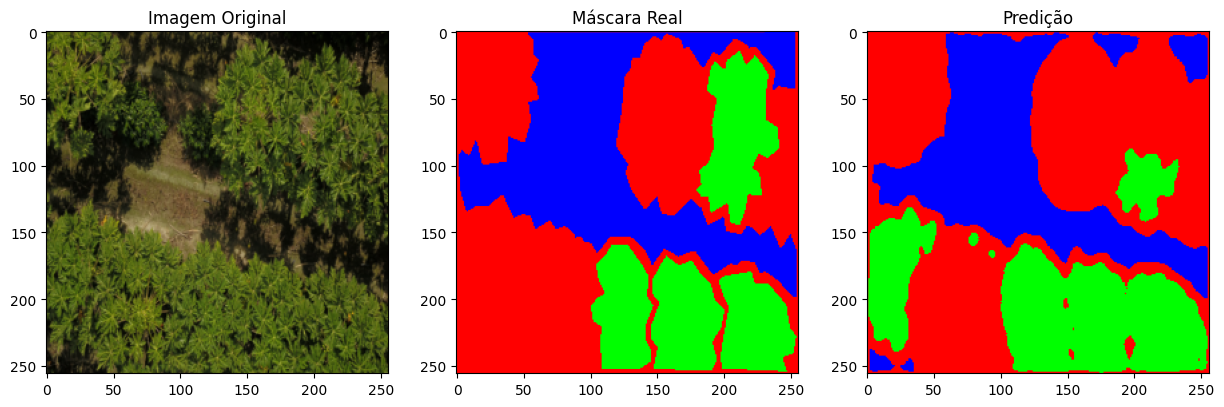

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


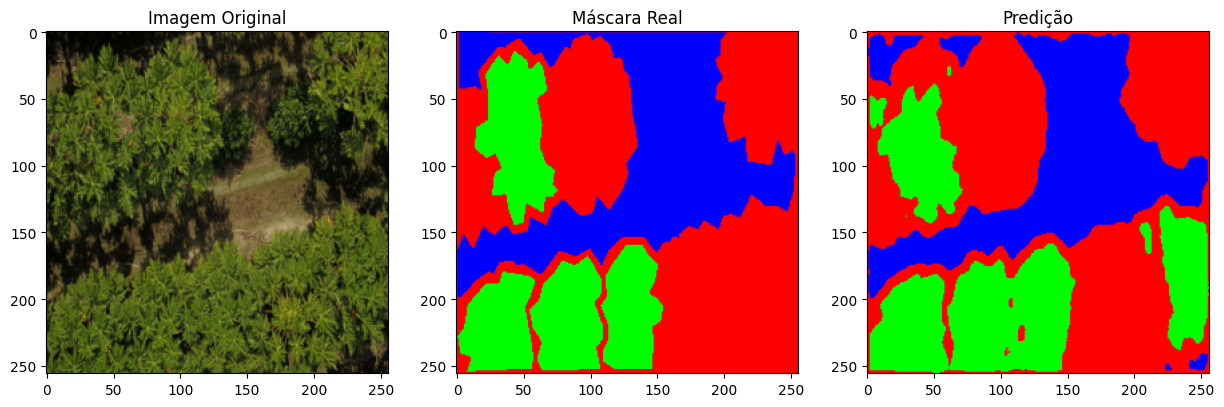

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


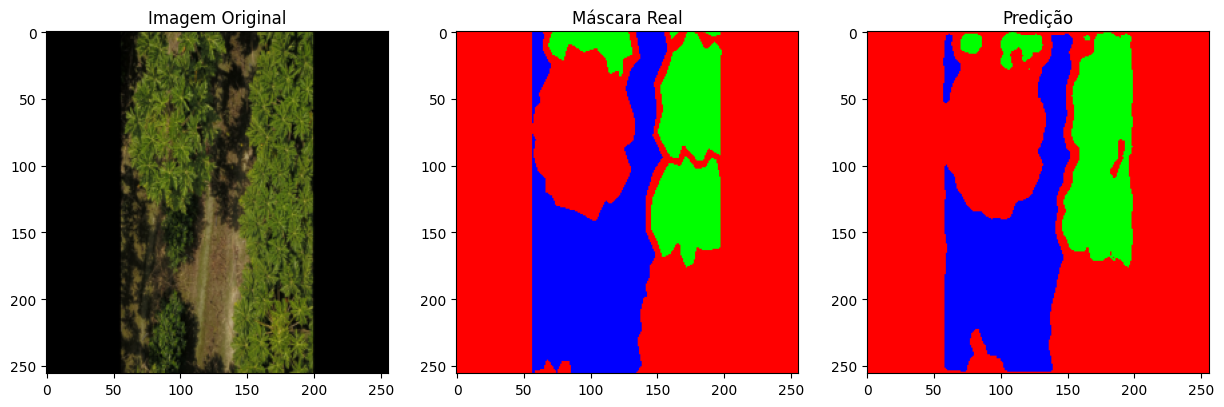

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


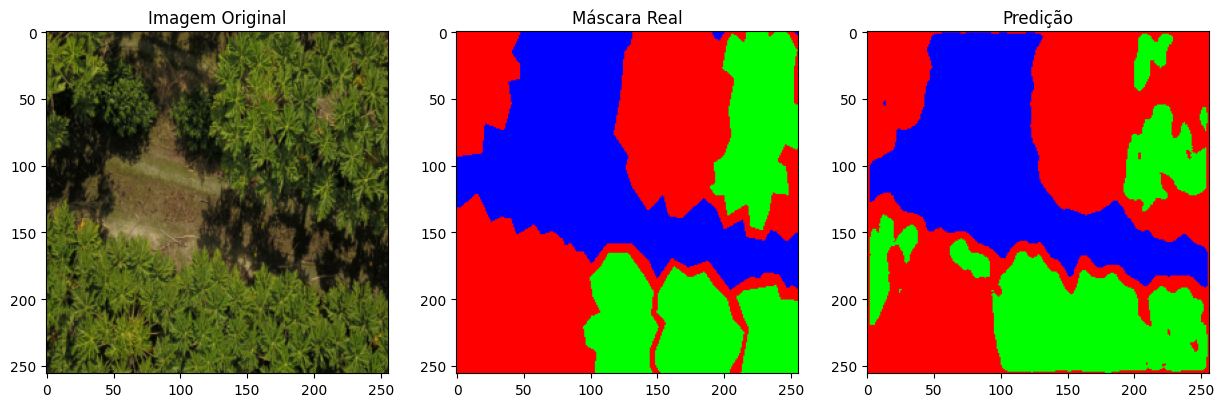

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


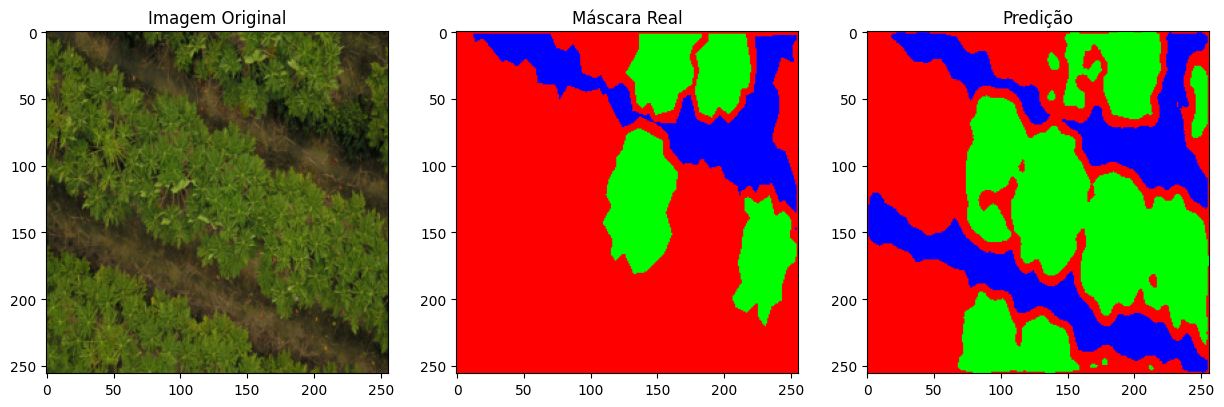

Visualizando e salvando predições para PSPNet...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


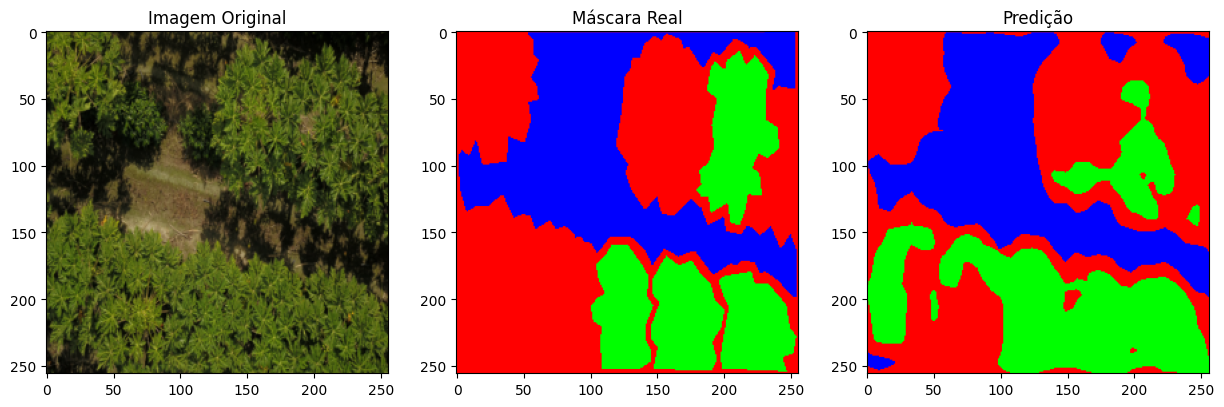

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


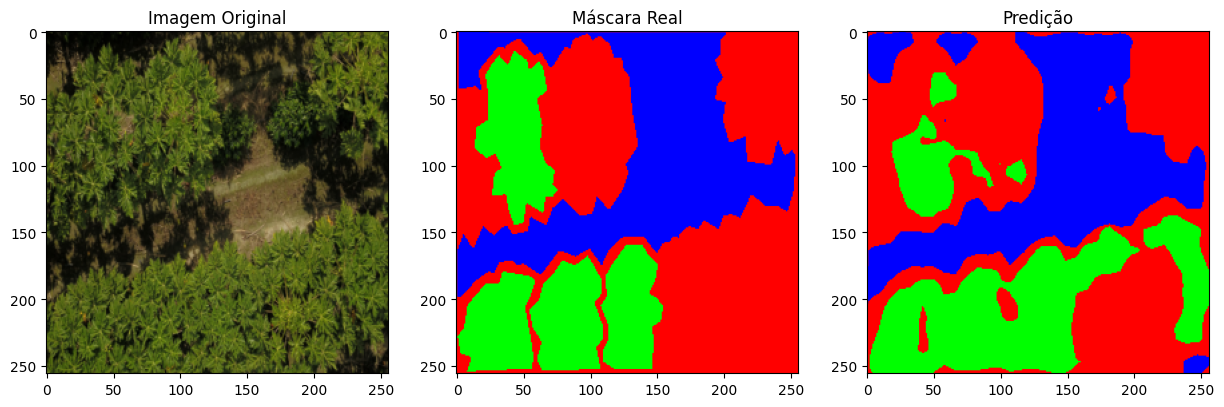

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


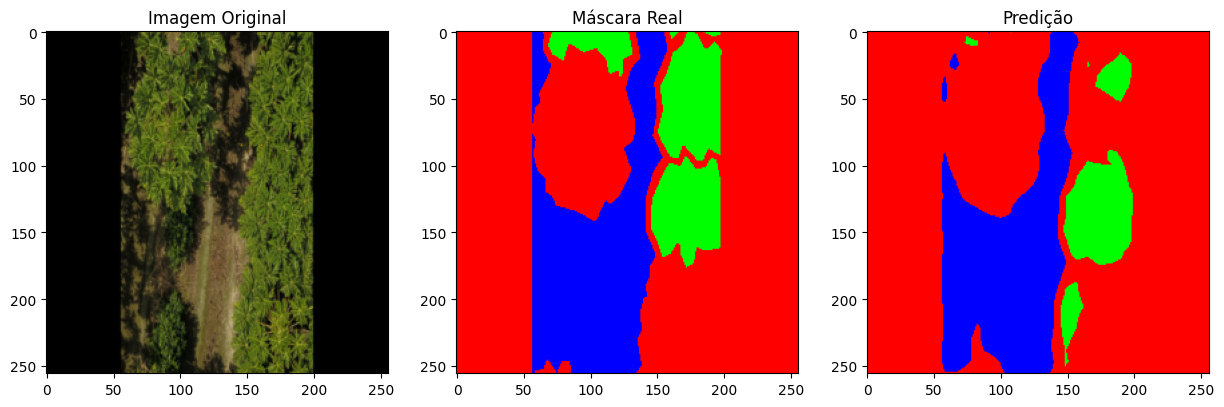

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


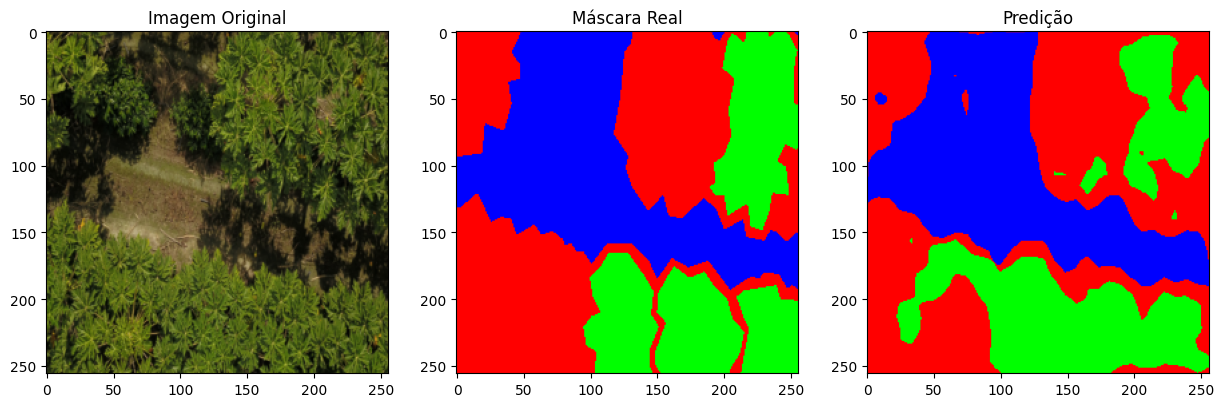

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


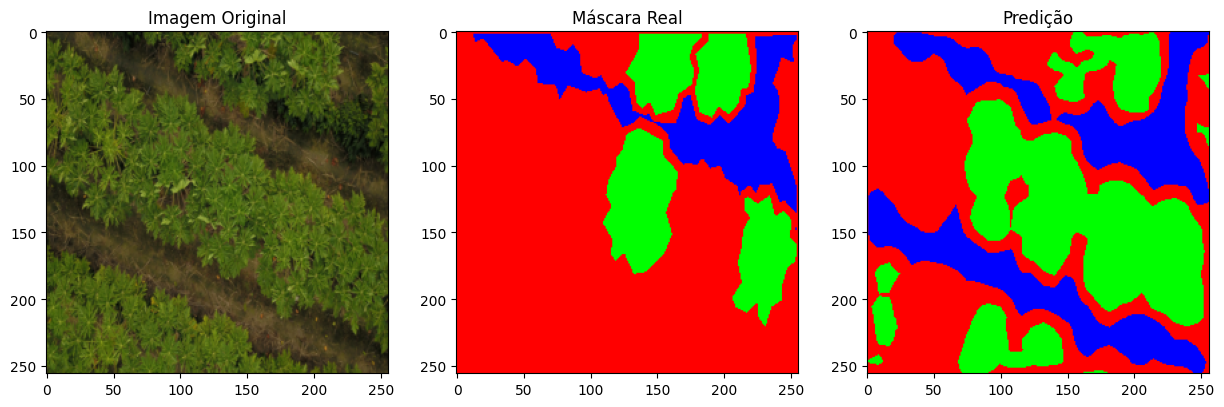

Visualizando e salvando predições para LinkNet...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


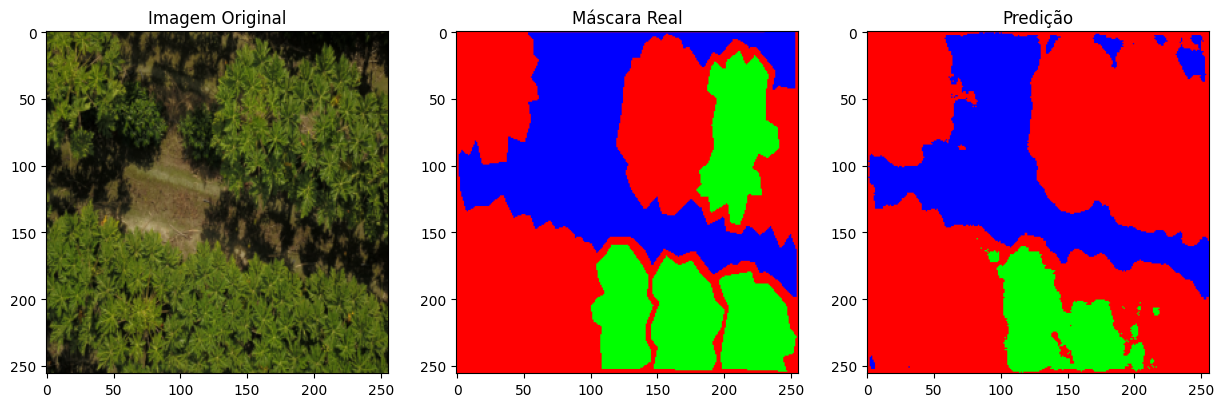

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


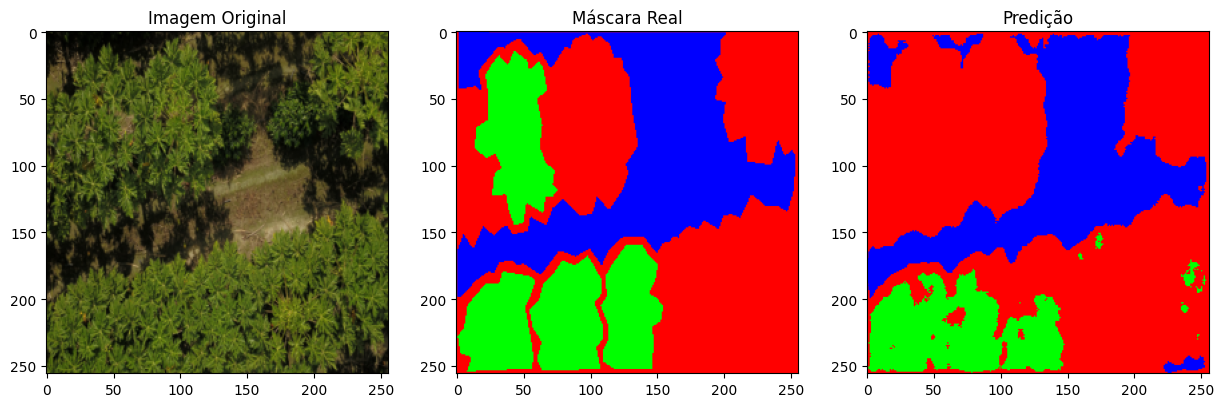

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


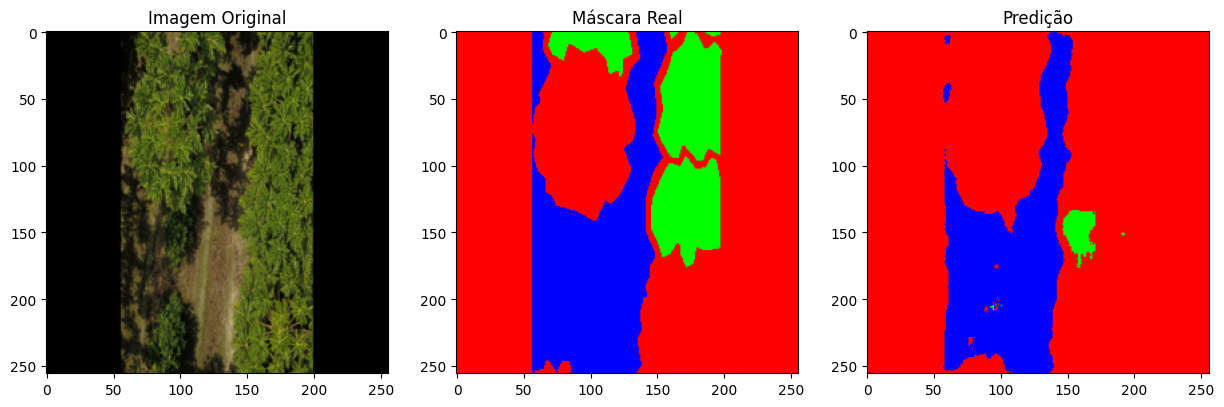

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


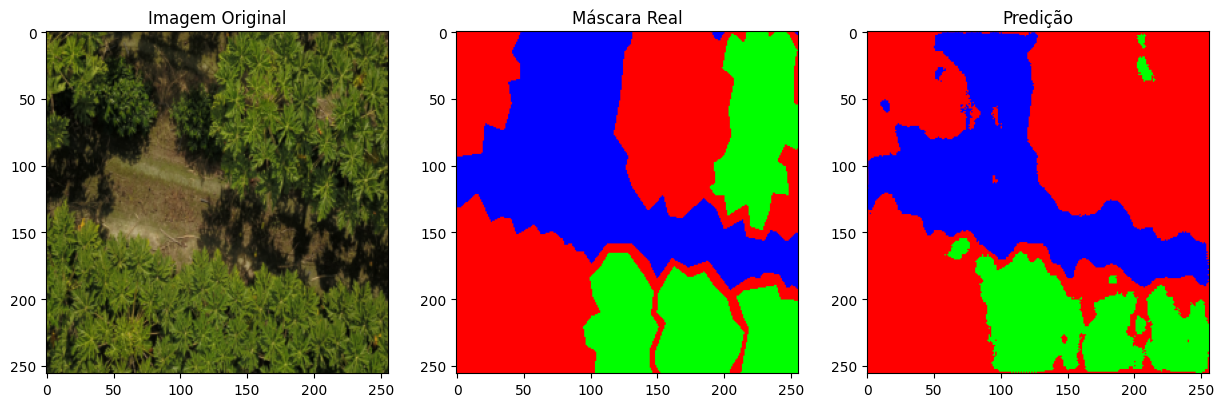

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


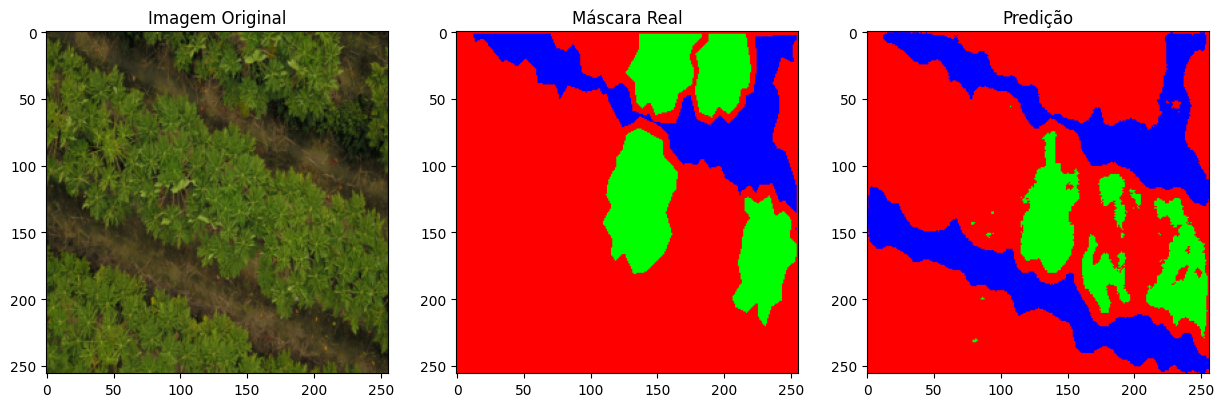

Visualizando e salvando predições para DeepLabV3...
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


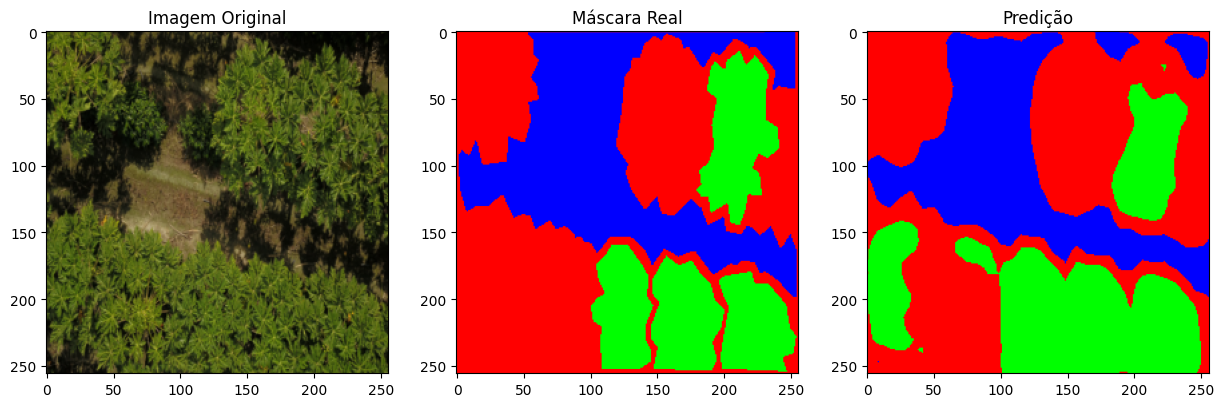

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


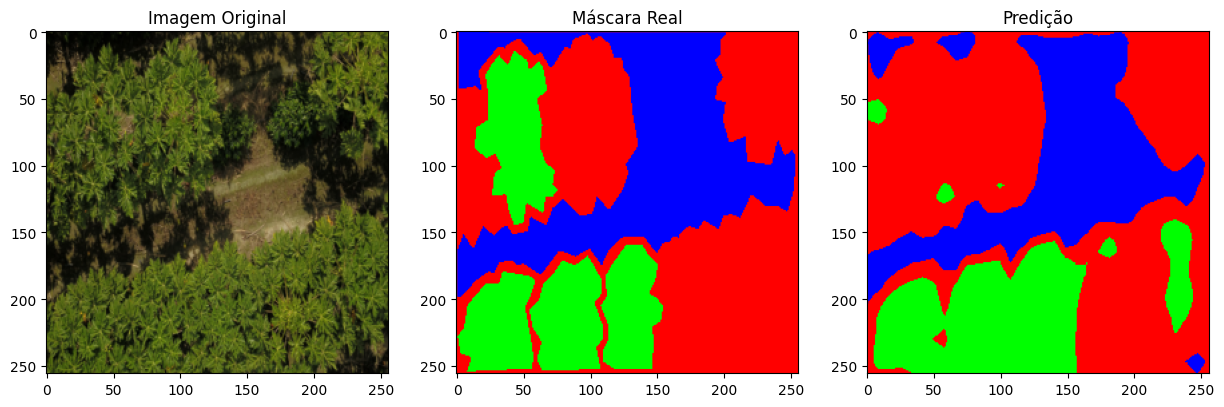

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


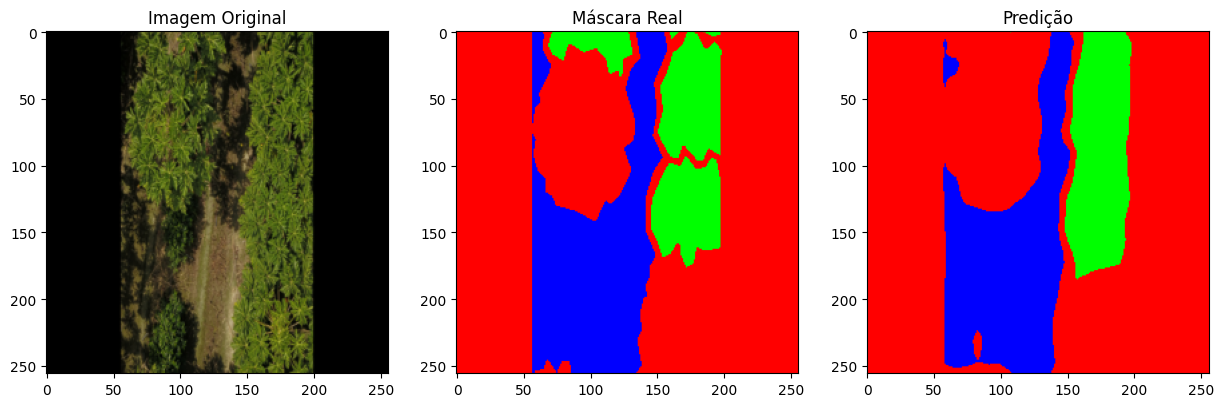

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


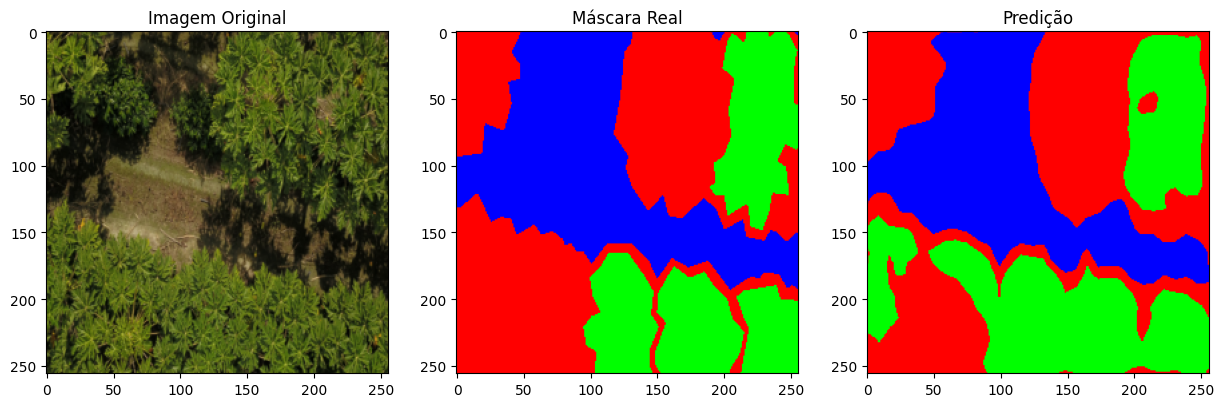

Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Unique classes in mask: [0 1 2]
Mapping class 0 to color (255, 0, 0)
Mapping class 1 to color (0, 255, 0)
Mapping class 2 to color (0, 0, 255)
Input shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Prediction shape: torch.Size([256, 256])


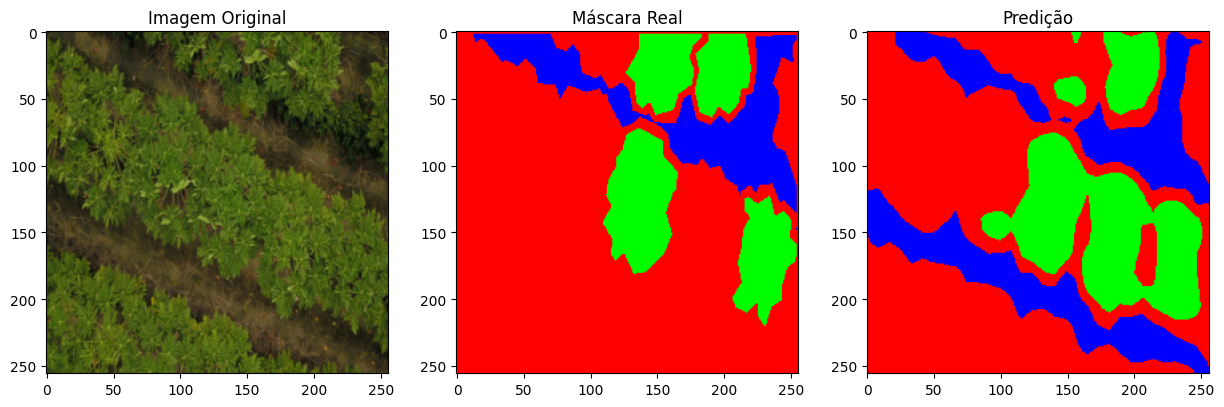

Visualização e salvamento concluídos!


In [13]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# Diretório para salvar os resultados das imagens
results_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/images"
os.makedirs(results_dir, exist_ok=True)

# Diretório onde os arquivos do modelo foram salvados
model_dir = "E:/Mestrado/Materias/2024-02-Sistemas para Processamento Multimidia/seminario/image-segmentation/results/data" 

# Função auxiliar para transformar índices de classe em cores RGB
def class_to_rgb(mask_indices):
    mask_rgb = np.zeros((mask_indices.shape[0], mask_indices.shape[1], 3), dtype=np.uint8)
    unique_classes = np.unique(mask_indices)
    print(f"Unique classes in mask: {unique_classes}")  # Log para classes únicas

    for class_index, color in enumerate(CLASS_COLORS.values()):
        mask_rgb[mask_indices == class_index] = color
        print(f"Mapping class {class_index} to color {color}")  # Log para mapeamento
    return mask_rgb

# Função para visualizar e salvar predições
def visualize_and_save_predictions(model, data_loader, device, results_dir, model_name, num_images=5):
    model.eval()
    images_saved = 0

    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                images_saved += 1
                if images_saved > num_images:
                    return
                
                # Processamento para visualização
                image = (inputs[i].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                
                # Conversão de índices para RGB
                mask = class_to_rgb(masks[i].cpu().numpy())
                prediction = class_to_rgb(preds[i].cpu().numpy())

                # Logs para depuração
                print(f"Input shape: {inputs[i].shape}")
                print(f"Mask shape: {masks[i].shape}")
                print(f"Prediction shape: {preds[i].shape}")

                # Visualização
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Imagem Original')

                plt.subplot(1, 3, 2)
                plt.imshow(mask)
                plt.title('Máscara Real')

                plt.subplot(1, 3, 3)
                plt.imshow(prediction)
                plt.title('Predição')

                plt.show()
                
                # Salvar as imagens
                plt.imsave(os.path.join(results_dir, f'{model_name}_input_{images_saved}.png'), image)
                plt.imsave(os.path.join(results_dir, f'{model_name}_mask_{images_saved}.png'), mask)
                plt.imsave(os.path.join(results_dir, f'{model_name}_prediction_{images_saved}.png'), prediction)

# Executar para cada modelo
for model_name, model in models.items():
    print(f"Visualizando e salvando predições para {model_name}...")
    
    trained_model = model
    trained_model_path = os.path.join(model_dir, f'{model_name}_best.pth')
    trained_model.load_state_dict(torch.load(trained_model_path))
    trained_model.to(device)
    
    visualize_and_save_predictions(trained_model, test_loader, device, results_dir, model_name, num_images=5)

print("Visualização e salvamento concluídos!")